Apply the 3-pnt method to reconstruct the majority of the edges/hyper-edges
and then solve equations for the boundary nodes.

In [5]:
import sys
sys.path.append('/Users/evatakou/noise_est')
from color_code_stim import *
from noise_est_funcs_for_color_code import *
from utilities_for_color_code import *
from numerical_equations_for_color_code import *
from equations_for_d_3 import *



# from sims.color_code.noise_est_funcs_for_color_code import *
# from numerical_equations_for_color_code import *
import matplotlib.pyplot as plt 

import pymatching 
from pymatching import Matching 

import time


In [19]:
d          = 3
num_rounds = 1


p_circuit  = 1e-3
obj        = ColorCode(d=d,rounds=num_rounds,p_circuit=p_circuit) ##p_cnot=0,p_bitflip=0.01, p_circuit=1e-2 ,
circuit    = obj.circuit
nodes      =  collect_color_of_nodes(obj)
# circuit.diagram("timeline-svg")


In [20]:
num_ancilla   = len(obj.qubit_groups['anc'])
Z_dets,X_dets = get_Z_X_det_nodes(obj,num_rounds)
Z_DEM,X_DEM   = decompose_org_DEM_into_ZX_DEMs(circuit,Z_dets,X_dets)
#TODO: Fix the instructions of detectors inside of the DEMs when we separate them into Z and X type.

In [21]:
dems_stim                     = {}
ORG_DEM                       = []
pauli_decomposed_targets_dict = {}
pauli_decomposed_probs_dict   = {}

for color in ["r", "g", "b"]: 
    pauli_decomposed_targets_dict[color],pauli_decomposed_probs_dict[color],dem1, dem2 = obj.decompose_detector_error_model(ORG_DEM,color)
    dems_stim[color] = dem1, dem2  # stim.DetectorErrorModel
    

In [7]:
nodes

{'r': ['D2', 'D5'], 'g': ['D0', 'D3'], 'b': ['D1', 'D4']}

In [8]:
dems_stim['r'][1]

stim.DetectorErrorModel('''
    error(0.00504495) D11
    error(0.00504495) D2 D5
    error(0.00504495) D8
    error(0.00484654) D5
    error(0.00471432) D5 D14
    error(0.00458224) D7 L0
    error(0.00405306) D12 L0
    error(0.00352348) D14 L0
    error(0.00339091) D5 D12
    error(0.00325848) D9 L0
    error(0.00286063) D13 L0
    error(0.00272788) D5 D13
    error(0.00266116) D10 L0
    error(0.00259527) D2 D7
    error(0.00193118) D2 D6
    error(0.00193118) D2
    error(0.00133227) D5 D9
    error(0.0012662) D2 D9
    error(0.0012662) D6 L0
    error(0.00119929) D9
    error(0.000799787) D5 D10
    error(0.000799787) D2 D10
    error(0.000799787) D2 D12
    error(0.000533333) D2 L0
    error(0.000533333) D5 L0
    detector(3.5, 0, 0) D0
    detector(0.5, 1, 0) D1
    detector(3.5, 2, 0) D2
    shift_detectors(0, 0, 1) 0
    detector(3.5, 0, 0) D3
    detector(0.5, 1, 0) D4
    detector(3.5, 2, 0) D5
''')

In [9]:
dets_Z,dets_X = get_Z_X_det_nodes_as_rd_anc_pairs_dict(obj,num_rounds)


In [72]:
num_shots = 2*10**7
defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS = get_defects(circuit,num_rounds,num_shots,obj)

obs_flips = get_observable_flips(data_qubit_samples,d)

min_bound = 1e-12
max_bound = 0.6              #Sometimes solutions for the 3 pnt-event are sensitive to the bounds...
method    = "least_squares"  #minimize method is not reliable...

vi_mean_Z   = avg_vi(defects_matrix_Z)
vivj_mean_Z = avg_vivj(defects_matrix_Z.data)


In [73]:
p3_cnts_for_Z  = get_3_pnt_events_only_Z_new(defects_matrix_Z,obj,Z_DEM)
detector_type  = "Z"
vijk_for_Z     = get_vijk_new(p3_cnts_for_Z,num_rounds,vi_mean_Z,vivj_mean_Z,obj,detector_type)
sols_for_Z     = solve_for_probs(min_bound,max_bound,method,vijk_for_Z)

if len(defects_matrix_X)>0: #non-empty

    vi_mean_X      = avg_vi(defects_matrix_X) 
    vivj_mean_X    = avg_vivj(defects_matrix_X) 
    p3_cnts_for_X  = get_3_pnt_events_only_X_new(defects_matrix_X,obj,X_DEM,num_rounds) 
    detector_type  = "X" 
    vijk_for_X     = get_vijk_new(p3_cnts_for_X,num_rounds,vi_mean_X,vivj_mean_X,obj,detector_type) 
    sols_for_X     = solve_for_probs(min_bound,max_bound,method,vijk_for_X) 


In [74]:
#Get the edges for the Z_DEM
sols_for_defect_type           = sols_for_Z    
vi_mean                        = vi_mean_Z  
vivj_mean                      = vivj_mean_Z     
stims_DEM                      = Z_DEM    
defects_type                   = "Z" 
pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type) 
error_events_in_Z_DEM,my_Z_DEM = create_Z_DEM(pij_bd,pij_bulk,pij_time,p3,Z_DEM) 



In [75]:
def append_L0_to_edges(Z_DEM,pij_time,pij_bulk,pij_bd):

    pij_time_new = {}
    pij_bulk_new = {}
    pij_bd_new   = {}

    for instruction in Z_DEM:

        if instruction.type=="error":

            targets   = instruction.targets_copy()
            dets      = []
            dets_w_L0 = []

            for target in targets:
                if target.is_relative_detector_id():
                    id = target.val 
                    dets.append("D"+str(id))
                    dets_w_L0.append("D"+str(id))
                else:
                    dets_w_L0.append("L0")
            
            if tuple(dets) in pij_bulk.keys():
                pij_bulk_new[tuple(dets_w_L0)] = pij_bulk[tuple(dets)]
            
            if tuple(dets) in pij_time.keys():
                pij_time_new[tuple(dets_w_L0)] = pij_time[tuple(dets)]
            
           
            if len(dets)==1:
                    
                pij_bd_new[tuple(dets_w_L0)] = pij_bd[dets[0]]


    #Now put the new boundaries, by keeping only those with definite values:

            
    return pij_time_new,pij_bulk_new,pij_bd_new

pij_time,pij_bulk,pij_bd = append_L0_to_edges(Z_DEM,pij_time,pij_bulk,pij_bd)



In [76]:
max_order         = 2
sols,pij_bd_final = form_equations_for_all_boundaries_not_other_nodes_least_squares_V2(pij_time,pij_bulk,p3,pij_bd,
                                                                                       defects_matrix_Z,obj,num_rounds,
                                                                                       obs_flips,max_order,Z_DEM)


eq: 0.946930802249863*pD1L0*(1 - pD2L0)*(1 - pD5L0)*(-(0.00246072994394786 - pD2L0)/(1 - 2*pD2L0) + 1)*(-(0.00441901315070314 - pD1L0)/(1 - 2*pD1L0) + 1)*(-(0.0053388698817956 - pD5L0)/(1 - 2*pD5L0) + 1) + 0.00118895608330277*pD2L0*(1 - pD1L0)*(1 - pD5L0)*(-(0.00246072994394786 - pD2L0)/(1 - 2*pD2L0) + 1)*(-(0.00441901315070314 - pD1L0)/(1 - 2*pD1L0) + 1)*(-(0.0053388698817956 - pD5L0)/(1 - 2*pD5L0) + 1) + 0.00124912373366521*pD5L0*(1 - pD1L0)*(1 - pD2L0)*(-(0.00246072994394786 - pD2L0)/(1 - 2*pD2L0) + 1)*(-(0.00441901315070314 - pD1L0)/(1 - 2*pD1L0) + 1)*(-(0.0053388698817956 - pD5L0)/(1 - 2*pD5L0) + 1) + 1.6975775142232e-5*(1 - pD1L0)*(1 - pD2L0)*(1 - pD5L0)*(-(0.00246072994394786 - pD2L0)/(1 - 2*pD2L0) + 1)*(-(0.00441901315070314 - pD1L0)/(1 - 2*pD1L0) + 1)*(-(0.0053388698817956 - pD5L0)/(1 - 2*pD5L0) + 1) - 0.0030531000000016
eq: 0.00118895608330277*pD1L0*(1 - pD2L0)*(1 - pD5L0)*(-(0.00246072994394786 - pD2L0)/(1 - 2*pD2L0) + 1)*(-(0.00441901315070314 - pD1L0)/(1 - 2*pD1L0) + 1)*(-

In [77]:
def update_bd_edges(pij_bd,pij_bd_final):

    for key in pij_bd_final.keys():

        pij_bd[key]=pij_bd_final[key]

    return pij_bd
    
pij_bd = update_bd_edges(pij_bd,pij_bd_final)    



In [78]:
#Now construct the new_Z_DEM

def construct_Z_DEM_final(pij_bd_final,p3,pij_time_new,pij_bulk_new):

    my_Z_DEM = stim.DetectorErrorModel()

    for key in p3.keys():

        targets=[]
        for det in key:
            ind = int(det[1:])
            targets.append(stim.target_relative_detector_id(ind))

        my_Z_DEM.append("error",p3[key],targets)


    for key in pij_time_new.keys():

        targets=[]
        for det in key:
            if det[0]=="D":
                ind = int(det[1:])
                targets.append(stim.target_relative_detector_id(ind))
            else: #logical
                targets.append(stim.target_logical_observable_id(0))

        my_Z_DEM.append("error",pij_time_new[key],targets)


    for key in pij_bulk_new.keys():

        targets=[]
        for det in key:
            if det[0]=="D":
                ind = int(det[1:])
                targets.append(stim.target_relative_detector_id(ind))
            else: #logical
                targets.append(stim.target_logical_observable_id(0))

        my_Z_DEM.append("error",pij_bulk_new[key],targets)


    for key in pij_bd_final.keys():

        targets = []

        for det in key:

            if det[0]=="D":
                ind = int(det[1:])
                targets.append(stim.target_relative_detector_id(ind))
            else:
                targets.append(stim.target_logical_observable_id(0))
        
        prob = pij_bd_final[key]
        my_Z_DEM.append("error",prob,targets)
            

    return my_Z_DEM

my_Z_DEM = construct_Z_DEM_final(pij_bd,p3,pij_time,pij_bulk)

bd_stim: {('D0', 'L0'): 0.004582241746532972, ('D1',): 0.0011992888888887063, ('D1', 'L0'): 0.003258480791344033, ('D2',): 0.001931182734310662, ('D2', 'L0'): 0.000533333333333148, ('D3', 'L0'): 0.004053055241335569, ('D4', 'L0'): 0.003523480286975192, ('D5',): 0.0048465350479526634, ('D5', 'L0'): 0.000533333333333148}
bd_mine: {('D0', 'L0'): 0.004582003815904123, ('D1',): 0.0011925736920841326, ('D1', 'L0'): 0.0032341533911198397, ('D2',): 0.0019278683973293037, ('D2', 'L0'): 0.0005349240730493604, ('D3', 'L0'): 0.004046504558846364, ('D4', 'L0'): 0.003513779660761829, ('D5',): 0.004806231307826425, ('D5', 'L0'): 0.0005378082355275787}


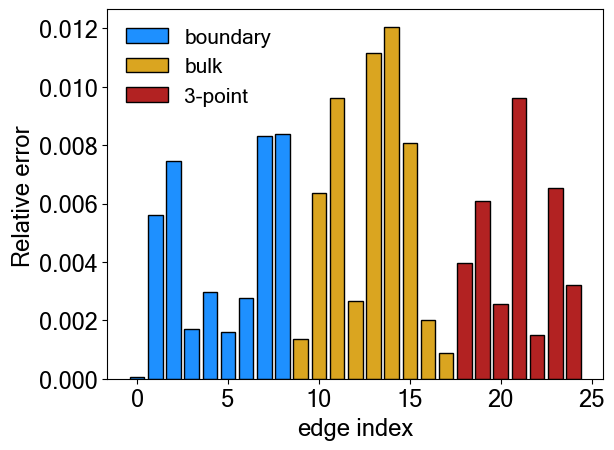

In [ ]:
#Compare the edges of the 2 DEMS
import matplotlib
from matplotlib import pyplot as plt 

def relative_error_of_edges(stims_DEM,my_DEM):

    errors_in_stims_DEM = {}
    for instruction in stims_DEM:
        if instruction.type=="error":
            
            targets = instruction.targets_copy()
            prob    = instruction.args_copy()[0]
            dets    = []
            for target in targets:
                if target.is_relative_detector_id():
                    id = target.val
                    dets.append("D"+str(id))
                else:
                    dets.append("L0")

            errors_in_stims_DEM[tuple(dets)]=prob

    errors_in_my_DEM = {}

    for instruction in my_DEM:
        if instruction.type=="error":
            
            targets = instruction.targets_copy()
            prob    = instruction.args_copy()[0]
            dets    = []
            for target in targets:
                if target.is_relative_detector_id():
                    id = target.val
                    dets.append("D"+str(id))
                else:
                    dets.append("L0")

            errors_in_my_DEM[tuple(dets)]=prob

    rel_error_p3 = {}
    rel_error_p2 = {}
    rel_error_p1 = {}

    bd_stim = {}
    bd_mine = {}
    for key in errors_in_stims_DEM.keys():

        p_true  = errors_in_stims_DEM[key]
        p_est   = errors_in_my_DEM[key]

        if len(key)==3:
            if key[1]=="L0":
                rel_error_p2[key] = abs(p_true-p_est)/p_true 
            else:
                rel_error_p3[key] = abs(p_true-p_est)/p_true 
        if len(key)==2:
            
            if key[1]=="L0":
                
                rel_error_p1[key] = abs(p_true-p_est)/p_true 
                bd_stim[key] = p_true 
                bd_mine[key] = p_est

            else:
                rel_error_p2[key] = abs(p_true-p_est)/p_true 


        if len(key)==1:
            rel_error_p1[key] = abs(p_true-p_est)/p_true
            bd_stim[key] = p_true 
            bd_mine[key] = p_est


    return rel_error_p1, rel_error_p2, rel_error_p3, bd_stim,bd_mine

rel_error_p1, rel_error_p2, rel_error_p3, bd_stim,bd_mine = relative_error_of_edges(Z_DEM,my_Z_DEM)

fig, ax = plt.subplots()

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"    


x1 = np.arange(len(rel_error_p1.keys()))
x2 = np.arange(x1[-1]+1,len(rel_error_p2.keys())+x1[-1]+1)
x3 = np.arange(x2[-1]+1,len(rel_error_p3.keys())+x2[-1]+1)

plt.bar(x=x1,height=list(rel_error_p1.values()),
        facecolor='dodgerblue',edgecolor='black')
plt.bar(x=x2,height=list(rel_error_p2.values()),
        facecolor='goldenrod',edgecolor='black')
plt.bar(x=x3,height=list(rel_error_p3.values()),
        facecolor='firebrick',edgecolor='black')

        
plt.legend(['boundary','bulk','3-point'],
           frameon=False,shadow=True,fontsize=15,loc='best')
plt.xlabel('edge index')
plt.ylabel('Relative error')

fig.savefig('bar_plot_d_3_r_1_error_1e_minus_3_N_est_2_10_7_Z_DEM_Edges.svg', format='svg', dpi=1500,bbox_inches='tight')

print("bd_stim:",bd_stim)
print("bd_mine:",bd_mine)

In [80]:
#Get the edges for the X_DEM
if len(defects_matrix_X)>0:

    sols_for_defect_type           = sols_for_X
    vi_mean                        = vi_mean_X 
    vivj_mean                      = vivj_mean_X 
    stims_DEM                      = X_DEM 
    defects_type                   = "X"
    pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)
    error_events_in_X_DEM,my_X_DEM = create_X_DEM(pij_bd,pij_bulk,pij_time,p3,X_DEM)
else:
    my_X_DEM = {}

In [22]:
r_only_DEM_mine,r_restricted_DEM_mine=create_lattices_new('r',my_Z_DEM,my_X_DEM,obj)
b_only_DEM_mine,b_restricted_DEM_mine=create_lattices_new('b',my_Z_DEM,my_X_DEM,obj)
g_only_DEM_mine,g_restricted_DEM_mine=create_lattices_new('g',my_Z_DEM,my_X_DEM,obj)

dems_mine      = {}
dems_mine['r'] = [r_restricted_DEM_mine,r_only_DEM_mine]
dems_mine['b'] = [b_restricted_DEM_mine,b_only_DEM_mine]
dems_mine['g'] = [g_restricted_DEM_mine,g_only_DEM_mine]

#Find the detector coordinates and pass them to my dems

for color in ['r','b','g']:

    for j in range(2):

        temp = dems_stim[color][j]
        
        for instruction in temp:
            if instruction.type=="error":
                continue 
            else:
                
                dems_mine[color][j].append(instruction)



In [23]:
num_shots = 5*10**6
det, obs  = obj.sample(num_shots)
preds_obs = obj.decode(det, dems_stim, verbose=False)

fails_stim = np.logical_xor(obs, preds_obs)
preds_obs  = obj.decode(det, dems_mine, verbose=False)
fails_mine = np.logical_xor(obs, preds_obs)

print("stim:",sum(fails_stim/num_shots))
print("mine:",sum(fails_mine/num_shots))

stim: 0.10632060000099744
mine: 0.10642280000100038


In [89]:
#Full function LE vs QEC rds
def compare_logical_error_rate(d,p_circuit,num_shots_for_est,num_shots,num_rounds):

    
    obj        = ColorCode(d=d,rounds=num_rounds,p_circuit=p_circuit) ##p_cnot=0,p_bitflip=0.01, p_circuit=1e-2 ,
    circuit    = obj.circuit
 
    num_ancilla   = len(obj.qubit_groups['anc'])
    Z_dets,X_dets = get_Z_X_det_nodes(obj,num_rounds)
    Z_DEM,X_DEM   = decompose_org_DEM_into_ZX_DEMs(circuit,Z_dets,X_dets)

    dems_stim                     = {}
    ORG_DEM                       = []
    pauli_decomposed_targets_dict = {}
    pauli_decomposed_probs_dict   = {}

    for color in ["r", "g", "b"]: 
        pauli_decomposed_targets_dict[color],pauli_decomposed_probs_dict[color],dem1, dem2 = obj.decompose_detector_error_model(ORG_DEM,color)
        dems_stim[color] = dem1, dem2  # stim.DetectorErrorModel


    #------- Estimation -------------------------------------
    # num_shots = 8*10**6
    defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS=get_defects(circuit,num_rounds,num_shots_for_est,obj)

    obs_flips = get_observable_flips(data_qubit_samples,d)

    min_bound = 1e-12
    max_bound = 0.6 #Sometimes solutions for the 3 pnt-event are sensitive to the max bound...
    method    =  "least_squares"  #minimize method does not work well

    vi_mean_Z      = avg_vi(defects_matrix_Z)
    vivj_mean_Z    = avg_vivj(defects_matrix_Z)
    p3_cnts_for_Z  = get_3_pnt_events_only_Z(defects_matrix_Z,obj)
    detector_type  = "Z"
    vijk_for_Z     = get_vijk_new(p3_cnts_for_Z,num_rounds,vi_mean_Z,vivj_mean_Z,obj,detector_type)
    sols_for_Z     = solve_for_probs(min_bound,max_bound,method,vijk_for_Z)

    if len(defects_matrix_X)>0: #non-empty

        vi_mean_X      = avg_vi(defects_matrix_X)
        vivj_mean_X    = avg_vivj(defects_matrix_X)
        p3_cnts_for_X  = get_3_pnt_events_only_X_new(defects_matrix_X,obj,X_DEM,num_rounds)
        detector_type  = "X"
        vijk_for_X     = get_vijk_new(p3_cnts_for_X,num_rounds,vi_mean_X,vivj_mean_X,obj,detector_type)
        sols_for_X     = solve_for_probs(min_bound,max_bound,method,vijk_for_X)


    sols_for_defect_type           = sols_for_Z
    vi_mean                        = vi_mean_Z 
    vivj_mean                      = vivj_mean_Z 
    stims_DEM                      = Z_DEM 
    defects_type                   = "Z"
    pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_ancilla,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)

    
    
    error_events_in_Z_DEM,my_Z_DEM = create_Z_DEM_new(pij_bd,pij_bulk,pij_time,p3,Z_DEM,defects_matrix_Z,obj,obs_flips,num_rounds)

    if len(defects_matrix_X)>0:

        sols_for_defect_type           = sols_for_X
        vi_mean                        = vi_mean_X 
        vivj_mean                      = vivj_mean_X 
        stims_DEM                      = X_DEM 
        defects_type                   = "X"
        pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_ancilla,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)
        error_events_in_X_DEM,my_X_DEM = create_X_DEM_new(pij_bd,pij_bulk,pij_time,p3,X_DEM,defects_matrix_X,obj,obs_flips,num_rounds)
    else:
        my_X_DEM={}

    r_only_DEM_mine,r_restricted_DEM_mine=create_lattices_new('r',my_Z_DEM,my_X_DEM,obj)
    b_only_DEM_mine,b_restricted_DEM_mine=create_lattices_new('b',my_Z_DEM,my_X_DEM,obj)
    g_only_DEM_mine,g_restricted_DEM_mine=create_lattices_new('g',my_Z_DEM,my_X_DEM,obj)

    dems_mine      = {}
    dems_mine['r'] = [r_restricted_DEM_mine,r_only_DEM_mine]
    dems_mine['b'] = [b_restricted_DEM_mine,b_only_DEM_mine]
    dems_mine['g'] = [g_restricted_DEM_mine,g_only_DEM_mine]

    #Find the detector coordinates and pass them to my dems

    for color in ['r','b','g']:

        for j in range(2):

            temp = dems_stim[color][j]
            
            for instruction in temp:
                if instruction.type=="error":
                    continue 
                else:
                    
                    dems_mine[color][j].append(instruction)

    # num_shots = 10**7
    det, obs  = obj.sample(num_shots)
    preds_obs = obj.decode(det, dems_stim, verbose=False)

    fails_stim = np.logical_xor(obs, preds_obs)
    preds_obs  = obj.decode(det, dems_mine, verbose=False)
    fails_mine = np.logical_xor(obs, preds_obs)


    stims_LE = sum(fails_stim)/num_shots
    my_LE    = sum(fails_mine)/num_shots

    return stims_LE,my_LE

def get_logical_error_rate_vs_QEC_rds(num_shots_for_est,num_shots,d,p,max_round):

    
    
    error_per_round_stim = []
    error_per_round_mine = []

    for rd in range(1,max_round+1):


        stims_LE,my_LE = compare_logical_error_rate(d,p,num_shots_for_est,num_shots,rd)
        
        error_per_round_stim.append(stims_LE)
        error_per_round_mine.append(my_LE)

    
    return error_per_round_stim,error_per_round_mine

num_shots_for_est = 10**6
num_shots         = 10**5
d                 = 7
p                 = 1e-2
max_round         = 3

error_per_round_stim,error_per_round_mine= \
    get_logical_error_rate_vs_QEC_rds(num_shots_for_est,num_shots,d,p,max_round)





In [90]:
error_per_round_stim

[0.03977, 0.11551, 0.19299]

In [91]:
error_per_round_mine

[0.0399, 0.1156, 0.19339]

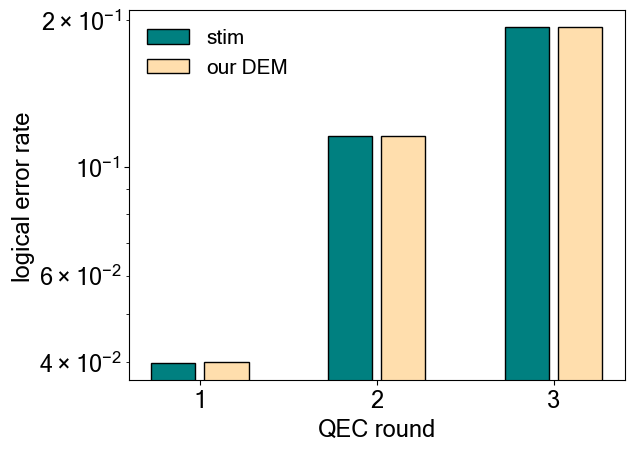

In [93]:
import matplotlib
fig, ax = plt.subplots()

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif" 

plt.bar(x=np.arange(1,max_round+1)-0.15,
        height=error_per_round_stim,width=0.25,edgecolor='black',
        facecolor='teal')
plt.bar(x=np.arange(1,max_round+1)+0.15,
        height=error_per_round_mine,width=0.25,edgecolor='black',
        facecolor='navajowhite')


plt.legend(["stim","our DEM"],frameon=False,
                 shadow=True,
                 fontsize=15)
plt.xlabel("QEC round")
plt.ylabel("logical error rate")
plt.yscale('log')

plt.xticks(ticks=np.arange(1,max_round+1)) 

fig.savefig('LE_per_rd_d_7_p_0.01_N_est_10_6_N_dec_10_5.svg', format='svg', dpi=1500,bbox_inches='tight')

In [104]:
#Full function:

#Try 1 RD for now to speed it up a bit

def compare_logical_error_rate(d,p_circuit,num_shots_for_est,num_shots):

    num_rounds = 1
    obj        = ColorCode(d=d,rounds=num_rounds,p_circuit=p_circuit) ##p_cnot=0,p_bitflip=0.01, p_circuit=1e-2 ,
    circuit    = obj.circuit
 
    num_ancilla   = len(obj.qubit_groups['anc'])
    Z_dets,X_dets = get_Z_X_det_nodes(obj,num_rounds)
    Z_DEM,X_DEM   = decompose_org_DEM_into_ZX_DEMs(circuit,Z_dets,X_dets)

    dems_stim                     = {}
    ORG_DEM                       = []
    pauli_decomposed_targets_dict = {}
    pauli_decomposed_probs_dict   = {}

    for color in ["r", "g", "b"]: 
        pauli_decomposed_targets_dict[color],pauli_decomposed_probs_dict[color],dem1, dem2 = obj.decompose_detector_error_model(ORG_DEM,color)
        dems_stim[color] = dem1, dem2  # stim.DetectorErrorModel



    #------- Estimation -------------------------------------
    # num_shots = 8*10**6
    defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS=get_defects(circuit,num_rounds,num_shots_for_est,obj)

    obs_flips = get_observable_flips(data_qubit_samples,d)

    min_bound = 1e-12
    max_bound = 0.6 #Sometimes solutions for the 3 pnt-event are sensitive to the max bound...
    method    =  "least_squares"  #minimize method does not work well

    vi_mean_Z      = avg_vi(defects_matrix_Z)
    vivj_mean_Z    = avg_vivj(defects_matrix_Z)
    p3_cnts_for_Z  = get_3_pnt_events_only_Z(defects_matrix_Z,obj)
    detector_type  = "Z"
    vijk_for_Z     = get_vijk_new(p3_cnts_for_Z,num_rounds,vi_mean_Z,vivj_mean_Z,obj,detector_type)
    sols_for_Z     = solve_for_probs(min_bound,max_bound,method,vijk_for_Z)

    if len(defects_matrix_X)>0: #non-empty

        vi_mean_X      = avg_vi(defects_matrix_X)
        vivj_mean_X    = avg_vivj(defects_matrix_X)
        p3_cnts_for_X  = get_3_pnt_events_only_X_new(defects_matrix_X,obj,X_DEM,num_rounds)
        detector_type  = "X"
        vijk_for_X     = get_vijk_new(p3_cnts_for_X,num_rounds,vi_mean_X,vivj_mean_X,obj,detector_type)
        sols_for_X     = solve_for_probs(min_bound,max_bound,method,vijk_for_X)


    sols_for_defect_type           = sols_for_Z
    vi_mean                        = vi_mean_Z 
    vivj_mean                      = vivj_mean_Z 
    stims_DEM                      = Z_DEM 
    defects_type                   = "Z"
    pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_ancilla,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)

    
    error_events_in_Z_DEM,my_Z_DEM = create_Z_DEM_new(pij_bd,pij_bulk,pij_time,p3,Z_DEM,defects_matrix_Z,obj,obs_flips,num_rounds)

    if len(defects_matrix_X)>0:

        sols_for_defect_type           = sols_for_X
        vi_mean                        = vi_mean_X 
        vivj_mean                      = vivj_mean_X 
        stims_DEM                      = X_DEM 
        defects_type                   = "X"
        pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_ancilla,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)
        error_events_in_X_DEM,my_X_DEM = create_X_DEM_new(pij_bd,pij_bulk,pij_time,p3,X_DEM,defects_matrix_X,obj,obs_flips,num_rounds)

    else:
        my_X_DEM = {}

        
    r_only_DEM_mine,r_restricted_DEM_mine=create_lattices_new('r',my_Z_DEM,my_X_DEM,obj)
    b_only_DEM_mine,b_restricted_DEM_mine=create_lattices_new('b',my_Z_DEM,my_X_DEM,obj)
    g_only_DEM_mine,g_restricted_DEM_mine=create_lattices_new('g',my_Z_DEM,my_X_DEM,obj)

    dems_mine      = {}
    dems_mine['r'] = [r_restricted_DEM_mine,r_only_DEM_mine]
    dems_mine['b'] = [b_restricted_DEM_mine,b_only_DEM_mine]
    dems_mine['g'] = [g_restricted_DEM_mine,g_only_DEM_mine]

    #Find the detector coordinates and pass them to my dems

    for color in ['r','b','g']:

        for j in range(2):

            temp = dems_stim[color][j]
            
            for instruction in temp:
                if instruction.type=="error":
                    continue 
                else:
                    
                    dems_mine[color][j].append(instruction)

    # num_shots = 10**7
    det, obs  = obj.sample(num_shots)
    preds_obs = obj.decode(det, dems_stim, verbose=False)

    fails_stim = np.logical_xor(obs, preds_obs)
    preds_obs  = obj.decode(det, dems_mine, verbose=False)
    fails_mine = np.logical_xor(obs, preds_obs)

    # print("stim:",sum(fails_stim))
    # print("mine:",sum(fails_mine))

    stims_LE = sum(fails_stim)/num_shots
    my_LE    = sum(fails_mine)/num_shots

    return stims_LE,my_LE

def get_logical_error_rate_vs_p_and_d(num_shots_for_est,num_shots):

    Ls               = [5,7]
    ps               = [1e-3,
                        2.5e-3,
                        5e-3,
                        1e-2,
                        2.5e-2,
                        5e-2]
    
    error_per_d_stim = []
    error_per_d_mine = []

    for d in Ls:

        error_per_p_stim = []
        error_per_p_mine = []
        for p_circuit in ps:
            
            stims_LE,my_LE = compare_logical_error_rate(d,p_circuit,num_shots_for_est,num_shots)
        
            error_per_p_stim.append(stims_LE)
            error_per_p_mine.append(my_LE)

        error_per_d_stim.append(error_per_p_stim)
        error_per_d_mine.append(error_per_p_mine)

    return Ls,ps,error_per_d_stim,error_per_d_mine

num_shots_for_est                       = 10**6
num_shots                               = 10**5
Ls,ps,error_per_d_stim,error_per_d_mine = get_logical_error_rate_vs_p_and_d(num_shots_for_est,num_shots)



numer/denom: -0.955695901840472


/Users/evatakou/myenv/sims/color_code/noise_est_funcs_for_color_code.py:525: RuntimeWarning: invalid value encountered in sqrt
  p      = 1/2  - np.sqrt(1/4- numer/denom)


Exception: Encountered nan value

In [100]:
error_per_d_stim

[[0.00038, 0.01093, 0.05408, 0.45774], [1e-05, 0.00469, 0.03899, 0.48273]]

In [19]:
error_per_d_mine

[[0.002678, 0.09281, 0.297246]]

In [9]:
rel_err_all =[]
for m in range(len(Ls)):
    temp_true = error_per_d_stim[m]
    temp_est  = error_per_d_mine[m]
    rel_err = []
    for k in range(len(temp_true)):
        val_true = temp_true[k]
        val_est  = temp_est[k]
        rel_err.append(abs(val_true-val_est)/val_true)
    rel_err_all.append(rel_err)

rel_err_all

[[0.0022455089820359016, 0.002257579015265554, 0.00024228229925907547]]

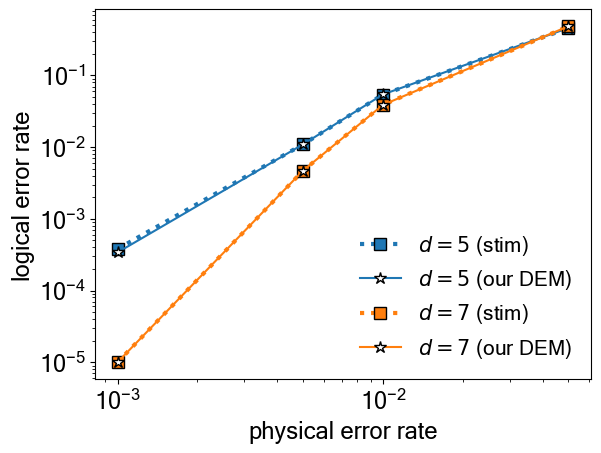

In [103]:
#Plot our results
from matplotlib import pyplot as plt 
import matplotlib
fig, ax = plt.subplots()

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"    
rel_err_all =[]
for m in range(len(Ls)):
    temp_true = error_per_d_stim[m]
    temp_est  = error_per_d_mine[m]
    rel_err = []
    for k in range(len(temp_true)):
        val_true = temp_true[k]
        val_est  = temp_est[k]
        rel_err.append(1-abs(val_true-val_est)/val_true)
    rel_err_all.append(rel_err)

colors = ['tab:blue','tab:orange','tab:green','tab:cyan','tab:purple']

cnt = 0
for L in Ls:
    
    
    plt.plot(ps,error_per_d_stim[cnt],marker='s',linestyle=':',color=colors[cnt]
                     ,linewidth=3,markeredgecolor='black',
                     markersize=9)
    plt.plot(ps,error_per_d_mine[cnt],marker='*',color=colors[cnt],
                     markersize=9,markeredgecolor='black',markerfacecolor='white')
    
    # plt.plot(ps,rel_err_all[cnt],marker='s')
    cnt+=1

    plt.legend(["$d=5$ (stim)","$d=5$ (our DEM)",
                "$d=7$ (stim)","$d=7$ (our DEM)",
                "$d=9$ (stim)","$d=9$ (our DEM)"],
                frameon=False,
                 shadow=True,
                 fontsize=15)
plt.xlabel("physical error rate")
plt.ylabel("logical error rate")
plt.yscale('log')
plt.xscale('log')
# plt.ylim([0.99,1])
# plt.title("$r=d$ rounds, memory experiment")

fig.savefig('threshold_TEST.svg', format='svg', dpi=1500,bbox_inches='tight')


Older codes below...



IGNORE

In [ ]:
num_shots = 10**7

sampler       = my_Z_DEM.compile_sampler() 

#detection_events, observable_flips = sampler.sample(shots = num_shots, separate_observables=True)
events_from_my_DEM  = sampler.sample(shots=num_shots)
flips_in_my_DEM     = events_from_my_DEM[1]
detection_events    = events_from_my_DEM[0]

matcher     = Matching.from_detector_error_model(my_Z_DEM)
predictions = matcher.decode_batch(detection_events)

num_errors_my_DEM = 0
for shot in range(num_shots):
    actual_for_shot    = flips_in_my_DEM[shot]
    predicted_for_shot = predictions[shot]
    if not np.array_equal(actual_for_shot, predicted_for_shot):
        num_errors_my_DEM += 1    


In [ ]:
sampler       = Z_DEM.compile_sampler() 

#detection_events, observable_flips = sampler.sample(shots = num_shots, separate_observables=True)
events_from_stim  = sampler.sample(shots=num_shots)
flips_in_stim     = events_from_stim[1]
detection_events  = events_from_stim[0]

matcher     = Matching.from_detector_error_model(Z_DEM)
predictions = matcher.decode_batch(detection_events)

num_errors_stim = 0
for shot in range(num_shots):
    actual_for_shot    = flips_in_stim[shot]
    predicted_for_shot = predictions[shot]
    if not np.array_equal(actual_for_shot, predicted_for_shot):
        num_errors_stim += 1    


In [ ]:
print("stim:",num_errors_stim)
print("our:",num_errors_my_DEM)

stim: 859118
our: 566430


In [ ]:
my_Z_DEM

stim.DetectorErrorModel('''
    error(0.0226321) D0 L0
    error(0.027442) D1 L0
    error(0.0275891) D2 L0
    error(0.0300792) D3 L0
    error(0.0250909) D4 L0
    error(0.030196) D5 L0
    error(0.0226325) D0 D1 D2
    error(0.00799852) D1 D2 D3
    error(0.00808856) D1 D3 D5
    error(0.0301266) D3 D4 D5
    error(0.0225713) D0 D1 L0
    error(0.0225991) D0 D2
    error(0.0225559) D1 D2
    error(0.02508) D3 D4 L0
    error(0.0301998) D3 D5
    error(0.0301629) D4 D5
    error(0.0106528) D0 D3
    error(0.0133068) D1 D3 L0
    error(0.0106824) D1 D4
    error(0.013102) D1 D5
    error(0.00801135) D2 D3
    error(0.0105619) D2 D5
''')

In [ ]:
def get_logical_error_rate(my_DEM,circuit,num_shots,decompose_errors):

    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=decompose_errors) 
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors_stim = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors_stim += 1

    #Now do the same for my DEM


    sampler       = my_DEM.compile_sampler() 

    #detection_events, observable_flips = sampler.sample(shots = num_shots, separate_observables=True)
    events_from_my_DEM  = sampler.sample(shots=num_shots)
    flips_in_my_DEM     = events_from_my_DEM[1]
    detection_events    = events_from_my_DEM[0]

    matcher     = Matching.from_detector_error_model(my_DEM)
    predictions = matcher.decode_batch(detection_events)

    num_errors_my_DEM = 0
    for shot in range(num_shots):
        actual_for_shot    = flips_in_my_DEM[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors_my_DEM += 1    

    return num_errors_stim/num_shots, num_errors_my_DEM/num_shots


In [ ]:
#MAYBE TRY THE DECODING TO SEE HOW MUCH THE BOUNDARIES AFFECT THE PROBLEM
#IF WE GET BETTER PERFORMANCE THEN IT WOULD BE INTERESTING?

array([0., 0., 0., 0., 0., 0.])

In [ ]:
def split_boundary_contribution_Z(pij_bd,defects_matrix_Z):
    
    num_shots   = np.shape(defects_matrix_Z)[0]
    num_ancilla = np.shape(defects_matrix_Z)[2]

    
    cnt_w_L0  = np.zeros(len(pij_bd.keys()))
    cnt_wo_L0 = np.zeros(len(pij_bd.keys()))

    for k in range(num_shots):

        locs = np.nonzero(defects_matrix_Z.data[k,:,:])

        if len(locs[0])==1 and len(locs[1])==1:

            rd  = locs[0]
            anc = locs[1]

            indx = anc + num_ancilla*rd 
            name = "D"+str(indx)

            if obs_flips[k]==True:

                cnt_w_L0[indx] = cnt_w_L0[indx]+1

            else:
                # if indx==0:
                #     print("D0 w/0 L0 happened?")
                    
                cnt_wo_L0[indx] = cnt_wo_L0[indx]+1

    ratio = cnt_w_L0/cnt_wo_L0
                
    pij_bd_new = {}
    for k in range(len(ratio)):
        
        if ratio[k]<1:
            pij_bd_new[("D"+str(k),"L0")] = ratio[k]*pij_bd[("D"+str(k))]


    return cnt_w_L0,cnt_wo_L0,pij_bd_new

cnt_w_L0,cnt_wo_L0,pij_bd_new=split_boundary_contribution_Z(pij_bd,defects_matrix_Z)

pij_bd_new

{('D2', 'L0'): 0.008633681025463783, ('D5', 'L0'): 0.009753554663518165}

In [ ]:
cnt_w_L0/num_shots

array([0.01508638, 0.01494013, 0.004678  , 0.02014712, 0.01671563,
       0.00538062])

In [ ]:
ratio=cnt_w_L0/cnt_wo_L0

In [ ]:
sols_for_Z[('D0', 'D1', 'D2')]

{'D0': 0.03280250892005976,
 'D1': 0.06873286870006705,
 'D2': 0.044977326838290116,
 ('D0', 'D1'): 0.022571484889610468,
 ('D0', 'D2'): 0.022599190258332975,
 ('D1', 'D2'): 0.030193737066563617,
 ('D0', 'D1', 'D2'): 0.022632452633567262}

In [ ]:
Z_DEM

stim.DetectorErrorModel('''
    error(0.0225669) D0 D1 D2
    error(0.0225669) D0 D1 L0
    error(0.0225669) D0 D2
    error(0.0106098) D0 D3
    error(0.0225669) D0 L0
    error(0.00533333) D1
    error(0.0225669) D1 D2
    error(0.00797863) D1 D2 D3
    error(0.00797863) D1 D3 D5
    error(0.0132269) D1 D3 L0
    error(0.0106098) D1 D4
    error(0.0132269) D1 D5
    error(0.0225669) D1 L0
    error(0.0225669) D2
    error(0.00797863) D2 D3
    error(0.0106098) D2 D5
    error(0.00533333) D2 L0
    error(0.0301854) D3 D4 D5
    error(0.02512) D3 D4 L0
    error(0.0301854) D3 D5
    error(0.0301854) D3 L0
    error(0.0301854) D4 D5
    error(0.02512) D4 L0
    error(0.02512) D5
    error(0.00533333) D5 L0
    detector(3.5, 0, 0) D0
    detector(0.5, 1, 0) D1
    detector(3.5, 2, 0) D2
    shift_detectors(0, 0, 1) 0
    detector(3.5, 0, 0) D3
    detector(0.5, 1, 0) D4
    detector(3.5, 2, 0) D5
''')

In [ ]:
cnt_w_L0  = 0
cnt_wo_L0 = 0
ratio     = 0
rd        = 0
anc       = 1
for k in range(num_shots):

    locs = np.nonzero(defects_matrix_Z.data[k,:,:])

    if len(locs[0])==1 and len(locs[1])==1:

        if locs[0]==rd and locs[1]==anc:

            if obs_flips[k] == True:
                cnt_w_L0 +=1 
            else:
                cnt_wo_L0 +=1


ratio = cnt_w_L0/cnt_wo_L0

ratio*pij_bd["D1"]
        



0.08022456724180678

In [ ]:
w_L0  = cnt_w_L0/num_shots
wo_L0 = cnt_wo_L0/num_shots

pij_bd["D1"]*(cnt_w_L0/cnt_wo_L0)

0.08022456724180678

In [ ]:
pij_bd["D1"]*(1-1/ratio)

0.018055073604951954

In [ ]:
Z_DEM

stim.DetectorErrorModel('''
    error(0.0225669) D0 D1 D2
    error(0.0225669) D0 D1 L0
    error(0.0225669) D0 D2
    error(0.0106098) D0 D3
    error(0.0225669) D0 L0
    error(0.00533333) D1
    error(0.0225669) D1 D2
    error(0.00797863) D1 D2 D3
    error(0.00797863) D1 D3 D5
    error(0.0132269) D1 D3 L0
    error(0.0106098) D1 D4
    error(0.0132269) D1 D5
    error(0.0225669) D1 L0
    error(0.0225669) D2
    error(0.00797863) D2 D3
    error(0.0106098) D2 D5
    error(0.00533333) D2 L0
    error(0.0301854) D3 D4 D5
    error(0.02512) D3 D4 L0
    error(0.0301854) D3 D5
    error(0.0301854) D3 L0
    error(0.0301854) D4 D5
    error(0.02512) D4 L0
    error(0.02512) D5
    error(0.00533333) D5 L0
    detector(3.5, 0, 0) D0
    detector(0.5, 1, 0) D1
    detector(3.5, 2, 0) D2
    shift_detectors(0, 0, 1) 0
    detector(3.5, 0, 0) D3
    detector(0.5, 1, 0) D4
    detector(3.5, 2, 0) D5
''')

In [ ]:
num_ancilla = len(obj.qubit_groups['anc'])
Z_dets,X_dets=get_Z_X_det_nodes_as_rd_anc_pairs_dict(obj,num_rounds,num_ancilla)

rd0,anc0    = Z_dets["D5"]
num_ancilla = np.shape(defects_matrix_Z)[2]
cnt         = 0

for k in range(num_shots):

    if defects_matrix_Z.data[k,rd0,anc0]==True and obs_flips[k]==True:

        flag=True
        # for rd in range(num_rounds+1):

        #     for anc in range(num_ancilla):

        #         if rd!=rd0 or anc!=anc0:

        #             if defects_matrix_Z.data[k,rd,anc]==False:
        #                 flag=True 
        #             else:
        #                 flag=False 
        #                 break
            
        #     if flag==False:
        #         break 
        
        if flag==True: 
            cnt+=1 


cnt/num_shots







0.00772325

In [ ]:
pij_bd[("D5")]

0.010643036336085376

In [ ]:
q=cnt/num_shots
(pij_bd[("D5")]-q)/(1-2*q)

0.002965594389827852

In [ ]:
collect_color_of_nodes(obj)

{'r': ['D2', 'D5'], 'g': ['D0', 'D3'], 'b': ['D1', 'D4']}

In [ ]:
Z_DEM

stim.DetectorErrorModel('''
    error(0.0191187) D0 D1 D2
    error(0.0126203) D0 D1 L0
    error(0.0255305) D0 D2
    error(0.0485405) D0 D3
    error(0.0442573) D0 L0
    error(0.0119289) D1
    error(0.0126203) D1 D2
    error(0.00797863) D1 D2 D3
    error(0.00797863) D1 D3 D5
    error(0.0261209) D1 D3 L0
    error(0.0485405) D1 D4
    error(0.0132269) D1 D5
    error(0.0318567) D1 L0
    error(0.0191187) D2
    error(0.00797863) D2 D3
    error(0.0485405) D2 D5
    error(0.00533333) D2 L0
    error(0.0267923) D3 D4 D5
    error(0.0280678) D3 D4 L0
    error(0.0331017) D3 D5
    error(0.039327) D3 L0
    error(0.0454693) D4 D5
    error(0.0343602) D4 L0
    error(0.0466945) D5
    error(0.00533333) D5 L0
    detector(3.5, 0, 0) D0
    detector(0.5, 1, 0) D1
    detector(3.5, 2, 0) D2
    shift_detectors(0, 0, 1) 0
    detector(3.5, 0, 0) D3
    detector(0.5, 1, 0) D4
    detector(3.5, 2, 0) D5
''')

In [ ]:
#Use obs_flips to see how we can identify the contribution of flip/no flip for the boundary events

def split_boundary_contribution_Z(pij_bd,obs_flips,defects_matrix_Z,obj,num_rounds,pij_bulk,pij_time,p3):

    num_shots   = np.shape(defects_matrix_Z)[0]
    num_ancilla = len(obj.qubit_groups['anc'])
    dets_Z,dets_X=get_Z_X_det_nodes_as_rd_anc_pairs_dict(obj,num_rounds,num_ancilla)

    locs_flips = np.nonzero(obs_flips)[0]
    locs_flips = set(locs_flips)
    no_flips   = set(np.arange(num_shots)) ^ locs_flips 
    no_flips   = list(no_flips)
    

    vi_mean_Z   = np.zeros((num_rounds+1,num_ancilla))
    vivj_mean_Z = np.zeros((num_rounds+1,num_rounds+1,num_ancilla,num_ancilla))
    
    
    defects_matrix_Z.data[no_flips,:,:]=0

    vi_mean_Z   = avg_vi(defects_matrix_Z)
    # vivj_mean_Z = avg_vivj(defects_matrix_Z)

    for key in pij_bd.keys():

        rd,anc = dets_Z[key]

        vi    = vi_mean_Z[rd,anc]
        DENOM = 1

        for key2 in pij_bulk.keys():
            if key in key2:
                DENOM *= 1-2*pij_bulk[key2]

        for key2 in p3.keys():
            if key in key2:
                DENOM *= 1-2*p3[key2]
        
        for key2 in pij_time.keys():
            if key in key2:
                DENOM *=1-2*pij_time[key2]

        print("w/o L0:")
        print(1/2 + (vi-1/2)/DENOM)



    return 

split_boundary_contribution_Z(pij_bd,obs_flips,defects_matrix_Z,obj,num_rounds,pij_bulk,pij_time,p3)



w/o L0:
-0.053459484061921136
w/o L0:
-0.08859199244982463
w/o L0:
-0.10831052165351285
w/o L0:
-0.11586724373224855
w/o L0:
-0.09862534492818409
w/o L0:
-0.16592064494257874


In [ ]:
Z_DEM

stim.DetectorErrorModel('''
    error(0.0191187) D0 D1 D2
    error(0.0126203) D0 D1 L0
    error(0.0255305) D0 D2
    error(0.0485405) D0 D3
    error(0.0442573) D0 L0
    error(0.0119289) D1
    error(0.0126203) D1 D2
    error(0.00797863) D1 D2 D3
    error(0.00797863) D1 D3 D5
    error(0.0261209) D1 D3 L0
    error(0.0485405) D1 D4
    error(0.0132269) D1 D5
    error(0.0318567) D1 L0
    error(0.0191187) D2
    error(0.00797863) D2 D3
    error(0.0485405) D2 D5
    error(0.00533333) D2 L0
    error(0.0267923) D3 D4 D5
    error(0.0280678) D3 D4 L0
    error(0.0331017) D3 D5
    error(0.039327) D3 L0
    error(0.0454693) D4 D5
    error(0.0343602) D4 L0
    error(0.0466945) D5
    error(0.00533333) D5 L0
    detector(3.5, 0, 0) D0
    detector(0.5, 1, 0) D1
    detector(3.5, 2, 0) D2
    shift_detectors(0, 0, 1) 0
    detector(3.5, 0, 0) D3
    detector(0.5, 1, 0) D4
    detector(3.5, 2, 0) D5
''')

In [ ]:


pij_bd[("D1")]*0.0661255

0.002833546716163989

In [ ]:
Z_DEM

stim.DetectorErrorModel('''
    error(0.0191187) D0 D1 D2
    error(0.0126203) D0 D1 L0
    error(0.0255305) D0 D2
    error(0.0485405) D0 D3
    error(0.0442573) D0 L0
    error(0.0119289) D1
    error(0.0126203) D1 D2
    error(0.00797863) D1 D2 D3
    error(0.00797863) D1 D3 D5
    error(0.0261209) D1 D3 L0
    error(0.0485405) D1 D4
    error(0.0132269) D1 D5
    error(0.0318567) D1 L0
    error(0.0191187) D2
    error(0.00797863) D2 D3
    error(0.0485405) D2 D5
    error(0.00533333) D2 L0
    error(0.0267923) D3 D4 D5
    error(0.0280678) D3 D4 L0
    error(0.0331017) D3 D5
    error(0.039327) D3 L0
    error(0.0454693) D4 D5
    error(0.0343602) D4 L0
    error(0.0466945) D5
    error(0.00533333) D5 L0
    detector(3.5, 0, 0) D0
    detector(0.5, 1, 0) D1
    detector(3.5, 2, 0) D2
    shift_detectors(0, 0, 1) 0
    detector(3.5, 0, 0) D3
    detector(0.5, 1, 0) D4
    detector(3.5, 2, 0) D5
''')

In [ ]:
def estimate_ZDEM(sols_for_Z,num_rounds,Z_DEM):
    '''Redefine the time edges for the X dem'''

    
    all_dets = []
    #Use X-DEM to find out which names of 3-pnt events we need
    for instruction in Z_DEM:

        if instruction.type=="error": #Get the 3 pnt events that we are interested in

            targets = instruction.targets_copy()
            dets    = []
            for tar in targets:
                if tar.is_relative_detector_id():

                    dets.append(tar)
            if len(dets)==3:
                temp = []
                for det in dets:
                    id = str(det.val)
                    temp.append("D"+id)
                
                all_dets.append(tuple(temp))

    #Now use the solutions we have to estimate the X-DEM

    temp_Z_DEM = {}   
    for key in all_dets:

        temp_Z_DEM[key] = sols_for_Z[key][key] #Add the 3 pnt event
    
    num_ancilla   = len(obj.qubit_groups['anc'])
    dets_Z,dets_X = get_Z_X_det_nodes_as_rd_anc_pairs_dict(obj,num_rounds,num_ancilla)
    
    pij_bulk = {}
    
    for m in range(len(all_dets)):

        key = all_dets[m]

        for other_key in sols_for_Z[key].keys():

            #Boundary
            if other_key[0]=="D":
                continue

            if len(other_key)==3:
                continue

            #Start with bulk edges
            det0 = other_key[0]
            det1 = other_key[1]

            rd0,anc0 = dets_Z[det0]
            rd1,anc1 = dets_Z[det1]

            if rd0!=rd1:
                continue

            p3=[]

            if rd0==0:

                for l in range(m+1,len(all_dets)):
                    key2 = all_dets[l]

                    if  key!=key2 and det0 in key2 or det1 in key2: # and
                        p3.append(sols_for_Z[key2][key2])

            else:

                for l in range(m,len(all_dets)):
                    key2 = all_dets[l]

                    if  key!=key2 and det0 in key2 or det1 in key2: # and
                        p3.append(sols_for_Z[key2][key2])

            try:

                for p in p3:

                    pij_bulk[other_key]=(pij_bulk[other_key]-p)/(1-2*p)

            except KeyError:
                pij_bulk[other_key]=sols_for_Z[key][other_key]

    pij_time = {}
    
    #Now continue with time edges:
    for m in range(len(all_dets)):

        key = all_dets[m]

        for other_key in sols_for_Z[key].keys():

            #Boundary
            if other_key[0]=="D":
                continue

            if len(other_key)==3:
                continue

            det0 = other_key[0]
            det1 = other_key[1]

            rd0,anc0 = dets_Z[det0]
            rd1,anc1 = dets_Z[det1]

            if rd0==rd1:
                continue

            
            p3=[]

            if rd0==0:
                

                for l in range(m,m+1):
                    print("l=",l)
                    key2 = all_dets[l]
                    print("key2 key2:",key2)

                    if  det0 in key2 or det1 in key2:  #key!=key2 and 
                        p3.append(sols_for_Z[key2][key2])

            else:

                for l in range(m,len(all_dets)):
                    key2 = all_dets[l]

                    if  key!=key2 and det0 in key2 or det1 in key2: 
                        p3.append(sols_for_Z[key2][key2])

            try:

                for p in p3:

                    pij_time[other_key]=(pij_time[other_key]-p)/(1-2*p)

            except KeyError:
                pij_time[other_key]=sols_for_Z[key][other_key]


    return pij_time


# estimate_ZDEM(sols_for_Z,num_rounds,Z_DEM)

#Get the bulk, boundary and time edges. 
#Put their initially estimated values in a dictionary
#In other dictionary put the 3 pnt events associated with those edges.


l= 1
key2 key2: ('D1', 'D2', 'D3')
l= 1
key2 key2: ('D1', 'D2', 'D3')
l= 2
key2 key2: ('D1', 'D3', 'D5')
l= 2
key2 key2: ('D1', 'D3', 'D5')


{('D1', 'D3'): 0.026321608262211874,
 ('D2', 'D3'): 0.007849411634615597,
 ('D1', 'D5'): 0.013251526823739299}

In [ ]:
sols_for_Z[("D1","D3","D5")]

{'D1': 0.12258272100373291,
 'D3': 0.11378067446699938,
 'D5': 0.13195574122763312,
 ('D1', 'D3'): 0.03393102007937788,
 ('D1', 'D5'): 0.013251526823739299,
 ('D3', 'D5'): 0.057896642132259306,
 ('D1', 'D3', 'D5'): 0.008001399789339017}

In [ ]:
sols_for_Z.keys()

dict_keys([('D0', 'D1', 'D2'), ('D0', 'D2', 'D4'), ('D1', 'D2', 'D3'), ('D2', 'D3', 'D4'), ('D0', 'D1', 'D5'), ('D0', 'D4', 'D5'), ('D1', 'D3', 'D5'), ('D3', 'D4', 'D5')])

In [ ]:
p=sols_for_Z[("D1","D2","D3")][("D1","D3")]
q=sols_for_Z[("D1","D2","D3")][("D1","D2","D3")]

(p-q)/(1-2*q)

0.02629197076309297

In [ ]:
Z_DEM

stim.DetectorErrorModel('''
    error(0.0191187) D0 D1 D2
    error(0.0126203) D0 D1 L0
    error(0.0255305) D0 D2
    error(0.0485405) D0 D3
    error(0.0442573) D0 L0
    error(0.0119289) D1
    error(0.0126203) D1 D2
    error(0.00797863) D1 D2 D3
    error(0.00797863) D1 D3 D5
    error(0.0261209) D1 D3 L0
    error(0.0485405) D1 D4
    error(0.0132269) D1 D5
    error(0.0318567) D1 L0
    error(0.0191187) D2
    error(0.00797863) D2 D3
    error(0.0485405) D2 D5
    error(0.00533333) D2 L0
    error(0.0267923) D3 D4 D5
    error(0.0280678) D3 D4 L0
    error(0.0331017) D3 D5
    error(0.039327) D3 L0
    error(0.0454693) D4 D5
    error(0.0343602) D4 L0
    error(0.0466945) D5
    error(0.00533333) D5 L0
    detector(3.5, 0, 0) D0
    detector(0.5, 1, 0) D1
    detector(3.5, 2, 0) D2
    shift_detectors(0, 0, 1) 0
    detector(3.5, 0, 0) D3
    detector(0.5, 1, 0) D4
    detector(3.5, 2, 0) D5
''')

In [ ]:
p=0.057896642132259306
q=0.0267923
(p-q)/(1-2*q)

0.0328654226592882

In [ ]:
Z_DEM

stim.DetectorErrorModel('''
    error(0.0191187) D0 D1 D2
    error(0.0126203) D0 D1 L0
    error(0.0255305) D0 D2
    error(0.0485405) D0 D3
    error(0.0442573) D0 L0
    error(0.0119289) D1
    error(0.0126203) D1 D2
    error(0.00797863) D1 D2 D3
    error(0.00797863) D1 D3 D5
    error(0.0261209) D1 D3 L0
    error(0.0485405) D1 D4
    error(0.0132269) D1 D5
    error(0.0318567) D1 L0
    error(0.0191187) D2
    error(0.00797863) D2 D3
    error(0.0485405) D2 D5
    error(0.00533333) D2 L0
    error(0.0267923) D3 D4 D5
    error(0.0280678) D3 D4 L0
    error(0.0331017) D3 D5
    error(0.039327) D3 L0
    error(0.0454693) D4 D5
    error(0.0343602) D4 L0
    error(0.0466945) D5
    error(0.00533333) D5 L0
    detector(3.5, 0, 0) D0
    detector(0.5, 1, 0) D1
    detector(3.5, 2, 0) D2
    shift_detectors(0, 0, 1) 0
    detector(3.5, 0, 0) D3
    detector(0.5, 1, 0) D4
    detector(3.5, 2, 0) D5
''')

In [ ]:
sols_for_Z[("D0","D1","D2")]

{'D0': 0.08859561596074747,
 'D1': 0.1252097180731737,
 'D2': 0.07735519020576663,
 ('D0', 'D1'): 0.012794703535623413,
 ('D0', 'D2'): 0.025630452241839293,
 ('D1', 'D2'): 0.020254127015224475,
 ('D0', 'D1', 'D2'): 0.019128583745959302}

In [ ]:
Z_DEM

stim.DetectorErrorModel('''
    error(0.0191187) D0 D1 D2
    error(0.0126203) D0 D1 L0
    error(0.0255305) D0 D2
    error(0.0485405) D0 D3
    error(0.0442573) D0 L0
    error(0.0119289) D1
    error(0.0126203) D1 D2
    error(0.00797863) D1 D2 D3
    error(0.00797863) D1 D3 D5
    error(0.0261209) D1 D3 L0
    error(0.0485405) D1 D4
    error(0.0132269) D1 D5
    error(0.0318567) D1 L0
    error(0.0191187) D2
    error(0.00797863) D2 D3
    error(0.0485405) D2 D5
    error(0.00533333) D2 L0
    error(0.0267923) D3 D4 D5
    error(0.0280678) D3 D4 L0
    error(0.0331017) D3 D5
    error(0.039327) D3 L0
    error(0.0454693) D4 D5
    error(0.0343602) D4 L0
    error(0.0466945) D5
    error(0.00533333) D5 L0
    detector(3.5, 0, 0) D0
    detector(0.5, 1, 0) D1
    detector(3.5, 2, 0) D2
    shift_detectors(0, 0, 1) 0
    detector(3.5, 0, 0) D3
    detector(0.5, 1, 0) D4
    detector(3.5, 2, 0) D5
''')

In [ ]:
num_ancilla = len(obj.qubit_groups['anc'])
dets_Z,dets_X = get_Z_X_det_nodes_as_rd_anc_pairs_dict(obj,num_rounds,num_ancilla)

dets_X

{'D6': (0, 0), 'D7': (0, 1), 'D8': (0, 2)}

In [ ]:
all_keys=list(sols.keys())
sols[all_keys[2]]

for k in range(len(all_keys)):
    val = sols[all_keys[k]][all_keys[k]]
    if val>5e-4:
        print("For:",all_keys[k],val)


For: ('D0', 'D1', 'D2') 0.019174799517058666
For: ('D1', 'D2', 'D3') 0.008088621202013323
For: ('D1', 'D3', 'D5') 0.007869411797946568
For: ('D3', 'D4', 'D5') 0.02694708456287626


In [ ]:
def collect_solutions_of_3_pnt_cnts(sols):
    
    p3_cnts={}
    for key in sols.keys():

        for other_key in sols[key].keys():

            if len(other_key)==3:
                
                p3_cnts[other_key]=sols[other_key][other_key]
                break


    return p3_cnts

p3_cnts_Z_DEM = collect_solutions_of_3_pnt_cnts(sols)

#Next just estimate time, bulk and boundary edges and update with the usual formula.
#Finally, repeat for the X-dem.
#Then we can do the decomposition of the DEMs into the color-restricted and color only DEMs.


In [ ]:
#Now estimate time edges and update them based on 3 pnt events

def estimate_time_edges(p3_cnts_Z_DEM):


    return 


The things below are old version (to be deleted)

In [ ]:
#Now X-defects looks correct!
num_shots = 500_000
defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS=get_defects(circuit,num_rounds,num_shots,obj)

num_ancilla   = len(Z_ANC_QUBITS)
Z_dets,X_dets = get_Z_X_det_nodes(obj,num_rounds,num_ancilla*2)

vi_mean   = {}
vivj_mean = {}

if len(defects_matrix_X)>0:

    vi_mean['X']    = avg_vi(defects_matrix_X)
    vivj_mean['X']  = avg_vivj(defects_matrix_X)
    
vi_mean['Z']    = avg_vi(defects_matrix_Z)
vivj_mean['Z']  = avg_vivj(defects_matrix_Z)


#From these 2 we can reconstruct exactly each color-restricted DEM1
pij_bulk = estimate_bulk_edges(num_ancilla,num_rounds,vi_mean,vivj_mean,Z_dets,X_dets)
pij_bd   = get_bd_probs_for_each_restricted_color(pij_bulk,vi_mean,nodes,num_rounds,num_ancilla,obj)

In [ ]:
p3_cnts = get_all_3_point_probs_new(defects_matrix_Z,nodes)

p3_cnts

red: [4, 5, 8, 13, 14, 17]
blue: [2, 3, 7, 11, 12, 16]
green: [0, 1, 6, 9, 10, 15]


{('D0', 'D2', 'D4'): 0.00182,
 ('D1', 'D2', 'D4'): 4.6e-05,
 ('D2', 'D4', 'D6'): 0.000126,
 ('D2', 'D4', 'D9'): 0.000642,
 ('D2', 'D4', 'D10'): 4e-06,
 ('D2', 'D4', 'D15'): 6e-06,
 ('D0', 'D3', 'D4'): 0.001324,
 ('D1', 'D3', 'D4'): 9.4e-05,
 ('D3', 'D4', 'D6'): 0.001858,
 ('D3', 'D4', 'D9'): 1.2e-05,
 ('D3', 'D4', 'D10'): 0.0,
 ('D3', 'D4', 'D15'): 4e-06,
 ('D0', 'D4', 'D7'): 0.0001,
 ('D1', 'D4', 'D7'): 5.2e-05,
 ('D4', 'D6', 'D7'): 0.001318,
 ('D4', 'D7', 'D9'): 0.0,
 ('D4', 'D7', 'D10'): 4e-06,
 ('D4', 'D7', 'D15'): 0.001088,
 ('D0', 'D4', 'D11'): 6e-06,
 ('D1', 'D4', 'D11'): 0.0,
 ('D4', 'D6', 'D11'): 0.0,
 ('D4', 'D9', 'D11'): 1e-05,
 ('D4', 'D10', 'D11'): 0.0,
 ('D4', 'D11', 'D15'): 2e-06,
 ('D0', 'D4', 'D12'): 0.001148,
 ('D1', 'D4', 'D12'): 0.0,
 ('D4', 'D6', 'D12'): 0.000704,
 ('D4', 'D9', 'D12'): 0.000726,
 ('D4', 'D10', 'D12'): 2e-06,
 ('D4', 'D12', 'D15'): 0.000664,
 ('D0', 'D4', 'D16'): 0.0,
 ('D1', 'D4', 'D16'): 0.0,
 ('D4', 'D6', 'D16'): 6e-06,
 ('D4', 'D9', 'D16'): 0.0,

In [ ]:
#Suppose D0,D2,D4

#Could use: P111 = pik pj + pi pjk + pk pij +pijk (1- all the rest)
#and solve for pijj

anc0,rd0 = 0,0 #D0
anc1,rd1 = 2,0 #D2
anc2,rd2 = 4,0 #D4

cnt_D0 = defects_matrix_Z.data[:,rd0,anc0]
cnt_D2 = defects_matrix_Z.data[:,rd1,anc1]
cnt_D4 = defects_matrix_Z.data[:,rd2,anc2]

cnt_D0D2 = sum(cnt_D0 & cnt_D2)/num_shots
cnt_D0D4 = sum(cnt_D0 & cnt_D4)/num_shots
cnt_D2D4 = sum(cnt_D2 & cnt_D4)/num_shots


cnt_D0D2D4 = sum(cnt_D0 & cnt_D2 & cnt_D4)/num_shots
cnt_D0     = sum(cnt_D0)/num_shots
cnt_D2     = sum(cnt_D2)/num_shots
cnt_D4     = sum(cnt_D4)/num_shots


(cnt_D0D2D4 )



0.018994

In [ ]:
nodes

{'r': ['D4', 'D5', 'D8', 'D13', 'D14', 'D17'],
 'g': ['D0', 'D1', 'D6', 'D9', 'D10', 'D15'],
 'b': ['D2', 'D3', 'D7', 'D11', 'D12', 'D16']}

In [ ]:
#D0 D3 D4

anc0,rd0 = 0,0 #D0
anc1,rd1 = 3,0 #D3
anc2,rd2 = 4,0 #D4

cnt_D0 = defects_matrix_Z.data[:,rd0,anc0]
cnt_D3 = defects_matrix_Z.data[:,rd1,anc1]
cnt_D4 = defects_matrix_Z.data[:,rd2,anc2]

cnt_D0D3 = sum(cnt_D0 & cnt_D3)/num_shots
cnt_D0D4 = sum(cnt_D0 & cnt_D4)/num_shots
cnt_D2D4 = sum(cnt_D3 & cnt_D4)/num_shots


cnt_D0D3D4 = sum(cnt_D0 & cnt_D3 & cnt_D4)/num_shots

cnt_D0 = sum(cnt_D0)/num_shots
cnt_D3 = sum(cnt_D3)/num_shots
cnt_D4 = sum(cnt_D4)/num_shots

(cnt_D0D3D4-cnt_D0*cnt_D3*cnt_D4)/(1-2*cnt_D0*cnt_D3*cnt_D4)

0.012579795932191487

In [ ]:
#D0 D4 D12

anc0,rd0 = 0,0 #D0
anc1,rd1 = 4,0 #D4
anc2,rd2 = 3,1 #D12

cnt_D0 = defects_matrix_Z.data[:,rd0,anc0]
cnt_D4 = defects_matrix_Z.data[:,rd1,anc1]
cnt_D12 = defects_matrix_Z.data[:,rd2,anc2]

cnt_D0D4 = sum(cnt_D0 & cnt_D4)/num_shots
cnt_D0D12 = sum(cnt_D0 & cnt_D12)/num_shots
cnt_D4D12 = sum(cnt_D4 & cnt_D12)/num_shots


cnt_D0D4D12 = sum(cnt_D0 & cnt_D4 & cnt_D12)/num_shots

cnt_D0 = sum(cnt_D0)/num_shots
cnt_D4 = sum(cnt_D4)/num_shots
cnt_D12 = sum(cnt_D12)/num_shots

(cnt_D0D4D12-cnt_D0*cnt_D4*cnt_D12)/(1-2*cnt_D0*cnt_D4*cnt_D12)

0.011989752733430604

In [ ]:
nodes

{'r': ['D4', 'D5', 'D8', 'D13', 'D14', 'D17'],
 'g': ['D0', 'D1', 'D6', 'D9', 'D10', 'D15'],
 'b': ['D2', 'D3', 'D7', 'D11', 'D12', 'D16']}

In [ ]:
#D0 D3 D4
anc0,rd0 = 0,0
anc1,rd1 = 3,0
anc2,rd2 = 4,0

include_pairs=[(rd0,anc0),(rd1,anc1),(rd2,anc2)]


exclude_pairs=[(0,2)] #D2: exclude the first blue before D3

get_3Point_prob_exclude(defects_matrix_Z,num_shots,include_pairs,exclude_pairs)

0.0125125

In [ ]:
#D1 D3 D5

anc0,rd0 = 1,0
anc1,rd1 = 3,0
anc2,rd2 = 5,0

include_pairs=[(rd0,anc0),(rd1,anc1),(rd2,anc2)]

#Exclude all first blue before D12: D2', 'D3', 'D7', 'D11'

# exclude_pairs=[] 

# get_3Point_prob_exclude(defects_matrix_Z,num_shots,include_pairs,exclude_pairs)

get_3Point_prob(defects_matrix_Z,num_shots,include_pairs)

0.0188535

In [ ]:
circuit.detector_error_model()

stim.DetectorErrorModel('''
    error(0.0191187) D0 D2 D4
    error(0.0126203) D0 D2 L0
    error(0.0126203) D0 D3 D4
    error(0.0318567) D0 D3 L0
    error(0.0132269) D0 D4 D12
    error(0.00533333) D0 D6
    error(0.0485405) D0 D9
    error(0.00533333) D0 D12 D14
    error(0.00797863) D0 D12 L0
    error(0.0191187) D1 D3 D5
    error(0.0126203) D1 D3 L0
    error(0.0255305) D1 D5
    error(0.0485405) D1 D10
    error(0.0442573) D1 L0
    error(0.0126203) D2 D4
    error(0.00797863) D2 D4 D9
    error(0.00533333) D2 D7
    error(0.00797863) D2 D9 D13
    error(0.0261209) D2 D9 L0
    error(0.0485405) D2 D11
    error(0.0132269) D2 D13
    error(0.00533333) D2 D13 D15
    error(0.0318567) D2 L0
    error(0.0119289) D3
    error(0.0191187) D3 D4 D6
    error(0.0126203) D3 D5 D6
    error(0.00797863) D3 D5 D10
    error(0.0132269) D3 D6 D14
    error(0.00797863) D3 D10 D14
    error(0.0261209) D3 D10 L0
    error(0.041203) D3 D12
    error(0.0126203) D4 D6 D7
    error(0.00797863) D4 D6

In [ ]:
p_3cnts     = get_all_3_point_probs_new(defects_matrix_Z,nodes)

red: [4, 5, 8, 13, 14, 17]
blue: [2, 3, 7, 11, 12, 16]
green: [0, 1, 6, 9, 10, 15]


In [ ]:
p3_cnts=get_all_3_point_probs(defects_matrix_Z)

In [ ]:
p3_cnts[("D0","D2","D4")]

0.019344

In [ ]:
p3_cnts[("D0","D12","D14")]

0.000968

In [ ]:
circuit.detector_error_model()

stim.DetectorErrorModel('''
    error(0.0191187) D0 D2 D4
    error(0.0126203) D0 D2 L0
    error(0.0126203) D0 D3 D4
    error(0.0318567) D0 D3 L0
    error(0.0132269) D0 D4 D12
    error(0.00533333) D0 D6
    error(0.0485405) D0 D9
    error(0.00533333) D0 D12 D14
    error(0.00797863) D0 D12 L0
    error(0.0191187) D1 D3 D5
    error(0.0126203) D1 D3 L0
    error(0.0255305) D1 D5
    error(0.0485405) D1 D10
    error(0.0442573) D1 L0
    error(0.0126203) D2 D4
    error(0.00797863) D2 D4 D9
    error(0.00533333) D2 D7
    error(0.00797863) D2 D9 D13
    error(0.0261209) D2 D9 L0
    error(0.0485405) D2 D11
    error(0.0132269) D2 D13
    error(0.00533333) D2 D13 D15
    error(0.0318567) D2 L0
    error(0.0119289) D3
    error(0.0191187) D3 D4 D6
    error(0.0126203) D3 D5 D6
    error(0.00797863) D3 D5 D10
    error(0.0132269) D3 D6 D14
    error(0.00797863) D3 D10 D14
    error(0.0261209) D3 D10 L0
    error(0.041203) D3 D12
    error(0.0126203) D4 D6 D7
    error(0.00797863) D4 D6

In [ ]:
#Let's try to use the expression:

# 1/2 - sqrt(1/4 - numer/denom)
#where denom = 1-2*(v_i0 +v_j0+v_k0 - 2(v_i0+v_j0+v_k0)+4*v_iov_j0v+k0)
#and numer = vi0vj0vk0-vi0<v_j0v_k0>

cnts_of_D0 = defects_matrix_Z.data[:,0,0]
cnts_of_D1 = defects_matrix_Z.data[:,0,1]
cnts_of_D2 = defects_matrix_Z.data[:,0,2]

v0 = sum(cnts_of_D0)/num_shots
v1 = sum(cnts_of_D1)/num_shots
v2 = sum(cnts_of_D2)/num_shots

v0v1 = sum(cnts_of_D0 & cnts_of_D1)/num_shots
v0v2 = sum(cnts_of_D0 & cnts_of_D2)/num_shots
v1v2 = sum(cnts_of_D1 & cnts_of_D2)/num_shots

v0v1v2 = sum(cnts_of_D0 & cnts_of_D1 & cnts_of_D2)/num_shots

# numer = v0v1v2 - v0*(v1v2)-v1*(v0v2)-v2*(v0v1)+2*v0*v1*v2
# denom = 1-2*( v0+v1+v2 -2*(v0v1+v0v2+v1v2) + 4*v0v1v2 )

# 1/2-np.sqrt(1/4-numer/denom)

v0v1


0.0387065

In [ ]:
circuit.detector_error_model()

stim.DetectorErrorModel('''
    error(0.0191187) D0 D1 D2
    error(0.0126203) D0 D1 L0
    error(0.0255305) D0 D2
    error(0.0485405) D0 D3
    error(0.0442573) D0 L0
    error(0.0119289) D1
    error(0.0126203) D1 D2
    error(0.00797863) D1 D2 D3
    error(0.00797863) D1 D3 D5
    error(0.0261209) D1 D3 L0
    error(0.0485405) D1 D4
    error(0.0132269) D1 D5
    error(0.0318567) D1 L0
    error(0.0191187) D2
    error(0.00797863) D2 D3
    error(0.0485405) D2 D5
    error(0.00533333) D2 L0
    error(0.0267923) D3 D4 D5
    error(0.0280678) D3 D4 L0
    error(0.0331017) D3 D5
    error(0.039327) D3 L0
    error(0.0454693) D4 D5
    error(0.0343602) D4 L0
    error(0.0466945) D5
    error(0.00533333) D5 L0
    detector(3.5, 0, 0) D0
    detector(0.5, 1, 0) D1
    detector(3.5, 2, 0) D2
    shift_detectors(0, 0, 1) 0
    detector(3.5, 0, 0) D3
    detector(0.5, 1, 0) D4
    detector(3.5, 2, 0) D5
''')

In [ ]:
p3_cnts = get_all_3_point_probs_new(defects_matrix_Z,nodes)

p3_cnts

red: [4, 5, 8, 13, 14, 17]
blue: [2, 3, 7, 11, 12, 16]
green: [0, 1, 6, 9, 10, 15]


{('D0', 'D2', 'D4'): 0.019344,
 ('D1', 'D2', 'D4'): 0.006496,
 ('D2', 'D4', 'D6'): 0.010084,
 ('D2', 'D4', 'D9'): 0.001592,
 ('D2', 'D4', 'D10'): 9.2e-05,
 ('D2', 'D4', 'D15'): 8.8e-05,
 ('D0', 'D3', 'D4'): 0.016972,
 ('D1', 'D3', 'D4'): 0.008492,
 ('D3', 'D4', 'D6'): 0.019672,
 ('D3', 'D4', 'D9'): 0.000204,
 ('D3', 'D4', 'D10'): 4.4e-05,
 ('D3', 'D4', 'D15'): 0.000248,
 ('D0', 'D4', 'D7'): 0.009104,
 ('D1', 'D4', 'D7'): 0.006616,
 ('D4', 'D6', 'D7'): 0.016808,
 ('D4', 'D7', 'D9'): 5.2e-05,
 ('D4', 'D7', 'D10'): 0.000132,
 ('D4', 'D7', 'D15'): 0.002224,
 ('D0', 'D4', 'D11'): 0.000204,
 ('D1', 'D4', 'D11'): 2e-05,
 ('D4', 'D6', 'D11'): 2.8e-05,
 ('D4', 'D9', 'D11'): 0.000308,
 ('D4', 'D10', 'D11'): 2.8e-05,
 ('D4', 'D11', 'D15'): 6.4e-05,
 ('D0', 'D4', 'D12'): 0.00256,
 ('D1', 'D4', 'D12'): 2e-05,
 ('D4', 'D6', 'D12'): 0.00158,
 ('D4', 'D9', 'D12'): 0.001808,
 ('D4', 'D10', 'D12'): 7.2e-05,
 ('D4', 'D12', 'D15'): 0.001636,
 ('D0', 'D4', 'D16'): 4e-06,
 ('D1', 'D4', 'D16'): 2.8e-05,
 ('D

In [ ]:
rd1,anc1 = 0,0
rd2,anc2 = 0,1
rd3,anc3 = 0,2

triplet = [(rd1,anc1),(rd2,anc2),(rd3,anc3)]
p_012   = get_3Point_prob(defects_matrix_Z,num_shots,triplet)
print("D0-D1-D2:",p_012)
rd1,anc1 = 0,1
rd2,anc2 = 0,2
rd3,anc3 = 1,0

triplet       = [(rd1,anc1),(rd2,anc2),(rd3,anc3)]
exclude_pairs = [(0,0),(1,1),(1,2)] #Exclude D0, D4, D5 (previous rd, and nodes in this round)
p_123         = get_3Point_prob_exclude(defects_matrix_Z,num_shots,triplet,exclude_pairs)
print("D1-D2-D3:",p_123)
        
rd1,anc1 = 0,1
rd2,anc2 = 1,0
rd3,anc3 = 1,2

triplet       = [(rd1,anc1),(rd2,anc2),(rd3,anc3)]
exclude_pairs = [(0,0),(0,2),(1,1)] #Exclude D0, D4, D2 (previous rd, and nodes in this round)
p_135         = get_3Point_prob_exclude(defects_matrix_Z,num_shots,triplet,exclude_pairs)
print("D1-D3-D5:",p_135)




D0-D1-D2: 0.005225555555555555
D1-D2-D3: 0.002767777777777778
D1-D3-D5: 0.003311111111111111


In [ ]:
circuit.detector_error_model()

stim.DetectorErrorModel('''
    error(0.0191187) D0 D1 D2
    error(0.0126203) D0 D1 L0
    error(0.0255305) D0 D2
    error(0.0485405) D0 D3
    error(0.0442573) D0 L0
    error(0.0053378) D1
    error(0.0126203) D1 D2
    error(0.00533333) D1 D2 D3
    error(0.00267382) D1 D2 D3 D6
    error(0.00334003) D1 D3 D5
    error(0.00200671) D1 D3 D5 D6
    error(0.00200671) D1 D3 D5 D6 D8
    error(0.000669799) D1 D3 D5 D8
    error(0.000669799) D1 D3 D6 D8 L0
    error(0.0112742) D1 D3 D6 L0
    error(0.000669799) D1 D3 D8 L0
    error(0.0138877) D1 D3 L0
    error(0.0430609) D1 D4
    error(0.000669799) D1 D4 D6
    error(0.00200671) D1 D4 D6 D8
    error(0.00334003) D1 D4 D8
    error(0.00797863) D1 D5
    error(0.00533333) D1 D5 D8
    error(0.000669799) D1 D6
    error(0.000669799) D1 D6 D8
    error(0.0053378) D1 D8
    error(0.0013387) D1 D8 L0
    error(0.0306) D1 L0
    error(0.0191187) D2
    error(0.00533333) D2 D3
    error(0.00267382) D2 D3 D6
    error(0.0461133) D2 D5
    err

In [ ]:
#Try this: P(a and b and c) = P(a) P(b|given a)P(c|given a and b)

pa = pij_bd['r']["D0"]
#now we need pb given a

rda,anca=0,0
rdb,ancb=0,1
rdc,ancc=0,2

pa=0
pb_given_a=0
pc_given_a_and_b=0
for k in range(num_shots):

    if defects_matrix_Z.data[k,rda,anca]==True:
        pa+=1
        if defects_matrix_Z.data[k,rdb,ancb]==True:
            pb_given_a +=1

            if defects_matrix_Z.data[k,rdc,ancc]==True:
                pc_given_a_and_b+=1

pa=pa/num_shots
pb_given_a=pb_given_a/num_shots
pc_given_a_and_b=pc_given_a_and_b/num_shots

pa*pb_given_a*pc_given_a_and_b

9.791820536008001e-05

In [ ]:
default_dems={}
for color in ['r', 'g', 'b']:
    dem1, dem2 = obj.decompose_detector_error_model(ORG_DEM=[],color=color) #my_ORG_DEM

    # dem1 = my_c_restr_DEMS[color]

    default_dems[color] = dem1, dem2  # stim.DetectorErrorModel

default_dems['r'][1]

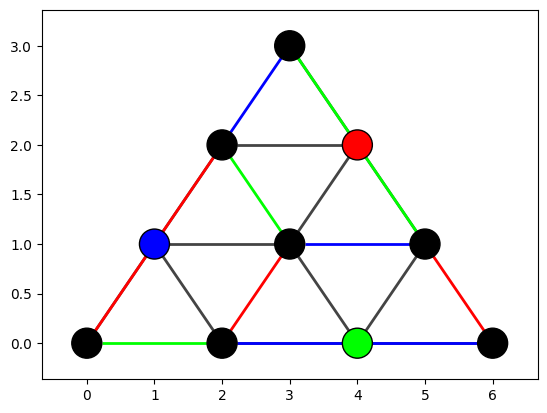

In [ ]:
from matplotlib import pyplot as plt
plt, ax = plt.subplots()
obj.draw_tanner_graph(ax=ax, show_axes=True,show_lattice=True)

In [ ]:
#Need a function that creates a dictionary (rd,anc) for Z/X dets



NameError: name 'get_Z_X_det_nodes_as_rd_anc_pairs' is not defined

In [ ]:
def get_bd_probs_for_each_restricted_color_new(pij_bulk,vi_mean,nodes,num_rounds,num_ancilla,Z_dets):
    '''nodes is a dictironary with keys the colors 'r', 'g', 'b' and values a list
     of detectors ["Dj", "Dk", ...]. 

     To find the boundary probabilities for a specific color restricted lattice,
     we need to exclude nodes that are of the particular color.
     For example, in the red-restricted lattice, we ignore any edges D_j - D_2 or D_j - D_5
     '''
    
    pij_bd={}

    for color in nodes.keys():
        
        pij_bd_per_color={}

        if color=='r': #do not use the red nodes
            remaining_nodes = nodes['g']+nodes['b']
        elif color=='g': #do not use the green nodes
            remaining_nodes = nodes['r']+nodes['b']
        else:            #do not use the blue nodes
            remaining_nodes = nodes['r']+nodes['g']
     
        for detector_node in remaining_nodes:

            INDX1    = int(detector_node[1:])
            (rd,anc) = detector_name_to_rd_anc_name(detector_node,num_ancilla,num_rounds)

            #Form all other combinations of this detector node with remaining nodes
            dets_to_exclude=[]
            
            for other_node in remaining_nodes:

                if other_node!=detector_node:
                    
                    INDX2 = int(other_node[1:])

                    indx1 = min([INDX1,INDX2])
                    indx2 = max([INDX1,INDX2])
                    temp  = ("D"+str(indx1),"D"+str(indx2))
                    dets_to_exclude.append(temp)

            val =  extract_bd_prob(pij_bulk,vi_mean,anc,rd,dets_to_exclude)
            
            if val<0:
                val=0

            pij_bd_per_color[("D"+str(INDX1))] = val

        pij_bd[color]=pij_bd_per_color


    return pij_bd


[('D0', 'D3'),
 ('D0', 'D9'),
 ('D3', 'D9'),
 ('D0', 'D1'),
 ('D0', 'D4'),
 ('D0', 'D10'),
 ('D1', 'D3'),
 ('D3', 'D4'),
 ('D3', 'D10'),
 ('D1', 'D9'),
 ('D4', 'D9'),
 ('D9', 'D10'),
 ('D0', 'D2'),
 ('D0', 'D5'),
 ('D0', 'D11'),
 ('D2', 'D3'),
 ('D3', 'D5'),
 ('D3', 'D11'),
 ('D2', 'D9'),
 ('D5', 'D9'),
 ('D9', 'D11'),
 ('D1', 'D4'),
 ('D1', 'D10'),
 ('D4', 'D10'),
 ('D1', 'D2'),
 ('D1', 'D5'),
 ('D1', 'D11'),
 ('D2', 'D4'),
 ('D4', 'D5'),
 ('D4', 'D11'),
 ('D2', 'D10'),
 ('D5', 'D10'),
 ('D10', 'D11'),
 ('D2', 'D5'),
 ('D2', 'D11'),
 ('D5', 'D11')]

In [ ]:
num_shots = 400_000

defects_matrix, data_qubit_samples,Z_ANC_QUBITS = get_defects(circuit,num_rounds,num_shots,obj)
obs_flips                                       = get_observable_flips(data_qubit_samples,num_shots,d)
vi_mean                                         = avg_vi(defects_matrix)
vivj_mean                                       = avg_vivj(defects_matrix)
events_w_L0                                     = get_events_that_cause_L0_flips(circuit)
num_ancilla                                     = len(Z_ANC_QUBITS)
Z_dets                                          = get_Z_det_nodes(obj,num_rounds,num_ancilla*2)
pij_bulk                                        = estimate_bulk_edges(num_ancilla,num_rounds,vi_mean,vivj_mean,Z_dets)

dets  = obj.detector_ids
nodes = {}
for key in dets.keys():
    vals = dets[key]
    temp = []
    for val in vals:
        temp.append("D"+str(val))
    nodes[key] =temp

# pij_bd_all      = get_bd_probs_for_each_restricted_color(pij_bulk,vi_mean,nodes,num_rounds,num_ancilla)
# my_c_restr_DEMS = get_color_restricted_DEMs(pij_bulk,pij_bd_all,nodes)
# p3_new          = get_all_3_point_probs_new(defects_matrix,nodes) #35 s for 200k shots. (6**3 combinations (6 nodes per color))


In [ ]:
from noise_estimation.utilities_for_noise_estimation_V2 import avg_vi, avg_vivj, bulk_prob_formula


def estimate_DEM(circuit,num_rounds,num_shots,obj,d):
    #----- Get the nodes --------------
    nodes=collect_color_of_nodes(obj)

    #------ Form defects matrix and calculate the probabilities -----------------------
    defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS = get_defects(circuit,num_rounds,num_shots,obj)
    
    defects_matrix =  defects_matrix_Z
    obs_flips      = get_observable_flips(data_qubit_samples,num_shots,d)
    vi_mean['Z']   = avg_vi(defects_matrix)
    vivj_mean['Z'] = avg_vivj(defects_matrix)
    events_w_L0    = get_events_that_cause_L0_flips(circuit)
    
    num_ancilla = len(Z_ANC_QUBITS)

    Z_dets,X_dets                                   = get_Z_X_det_nodes(obj,num_rounds,2*num_ancilla)
    pij_bulk    = estimate_bulk_edges(num_ancilla,num_rounds,vi_mean,vivj_mean,Z_dets,X_dets)
    # pij_bd      = get_all_bd_probs(pij_bulk,vi_mean)

    pij_bd_all      = get_bd_probs_for_each_restricted_color(pij_bulk,vi_mean,nodes,num_rounds,num_ancilla,obj)
    my_c_restr_DEMS = get_color_restricted_DEMs(pij_bulk,pij_bd_all,nodes)

    p1_cnts     = get_all_single_cnts_w_and_wo_L0(defects_matrix,obs_flips)
    p_3cnts     = get_all_3_point_probs_new(defects_matrix,nodes)
    p2_updated  = get_updated_probs_of_two_point_events(pij_bulk,p_3cnts,nodes)

    #------- Construct our own DEM (initial before breaking into 2 parts) ---------------

    org_DEM_Alt = {}
    for key in p2_updated.keys():

        if p2_updated[key]>0:
            if key in events_w_L0:
                key_new = key + ("L0",)
            else:
                key_new=key
            org_DEM_Alt[key_new]=p2_updated[key]

    for key in p1_cnts.keys():

        if p1_cnts[key]>0:
            org_DEM_Alt[key]=p1_cnts[key]
            
    for key in p_3cnts.keys():

        if p_3cnts[key]>0:
            org_DEM_Alt[key]=p_3cnts[key]


    my_ORG_DEM = stim.DetectorErrorModel()

    for key in org_DEM_Alt.keys():
        
        if org_DEM_Alt[key]<1e-4:
            continue
        temp = []
        for p in key:

            if len(p)>0 :
                if p[0]=="D":
                    indx = int(p[1:])
                    temp.append(stim.target_relative_detector_id(indx))
                elif p[0]=="L":
                    temp.append(stim.target_logical_observable_id(0))


        my_ORG_DEM.append("error",org_DEM_Alt[key],temp)


    my_ORG_DEM+=get_dets_from_stim_circuit(circuit)


    return my_ORG_DEM,defects_matrix,num_ancilla,obs_flips

def get_logical_errors(num_shots,num_rounds,circuit,obj,d):

    my_ORG_DEM,defects_matrix,num_ancilla,obs_flips=estimate_DEM(circuit,num_rounds,num_shots,obj,d)

    default_dems={}
    for color in ['r', 'g', 'b']:
        dem1, dem2 = obj.decompose_detector_error_model(ORG_DEM=[],color=color) #my_ORG_DEM

        # dem1 = my_c_restr_DEMS[color]

        default_dems[color] = dem1, dem2  # stim.DetectorErrorModel
    

    my_DEMs=get_my_DEMs(obj,my_ORG_DEM) #This is the decomposition: TODO: check if we can use instead the c-restricted DEM instead of 
                                        #decomposing the total DEM

    dets_alt = np.reshape(defects_matrix.data,(num_shots,num_ancilla*(num_rounds+1)))

    preds_obs, best_color = obj.decode(dets_alt, my_DEMs, verbose=False, get_color=True)

    my_fails = np.logical_xor(obs_flips, preds_obs)


    preds_obs, best_color = obj.decode(dets_alt, default_dems, verbose=False, get_color=True)

    fails = np.logical_xor(obs_flips, preds_obs)


    return my_fails,fails


def get_my_DEMs(obj,my_ORG_DEM):

    #Now get my DEMs
    my_DEMs={}
    for color in ['r', 'g', 'b']:
        dem1, dem2 = obj.decompose_detector_error_model(ORG_DEM=my_ORG_DEM,color=color) 

        # dem1_temp           = my_c_restr_DEMS[color]
        # #Make sure to put Ljs (logical errors) in my_c_restr_DEM

        # dem1_final = stim.DetectorErrorModel()
        # cnt=0
        # for instruction in dem1_temp:
        #     #Should we just put some random Ljs?
        #     targs = instruction.targets_copy()

        #     # indx=int(str(targs[0])[1:])+int(dem1.num_detectors)
        #     # cnt=indx

        #     targs.append(stim.target_logical_observable_id(cnt))

        #     cnt+=1
        #     dem1_final.append("error",instruction.args_copy(),targs)
        
        # dem1+= stim.DetectorErrorModel("""detector(3.5, 0, 0) D0
        #                 detector(0.5, 1, 0) D1
        #                 detector(3.5, 2, 0) D2
        #                 shift_detectors(0, 0, 1) 0
        #                 detector(3.5, 0, 0) D3
        #                 detector(0.5, 1, 0) D4
        #                 detector(3.5, 2, 0) D5""")

        # dem2+=stim.DetectorErrorModel("""detector(3.5, 0, 0) D0
        #                                 detector(0.5, 1, 0) D1
        #                                 detector(3.5, 2, 0) D2
        #                                 shift_detectors(0, 0, 1) 0
        #                                 detector(3.5, 0, 0) D3
        #                                 detector(0.5, 1, 0) D4
        #                                 detector(3.5, 2, 0) D5""")
        my_DEMs[color] = dem1, dem2  # stim.DetectorErrorModel
    return my_DEMs


# num_shots                  = 50_000
# my_ORG_DEM,defects_matrix,num_ancilla,obs_flips = estimate_DEM(circuit,num_rounds,num_shots,obj,d)

# my_ORG_DEM

In [ ]:
def get_logical_errors_per_error_rate(num_shots,obj,d,num_rounds):

    # d          = 3
    # num_rounds = 1
    
    # pvals = np.linspace(1e-3,1e-2,4)
    pvals=[1e-3,2e-3]

    my_LE    = []
    stims_LE = []
    for p in pvals:
    
        obj        = ColorCode(d=d,rounds=num_rounds,p_circuit=p ) ##p_cnot=0,p_bitflip=0.01
        circuit    = obj.circuit

        my_fails,fails = get_logical_errors(num_shots,num_rounds,circuit,obj,d)

        my_fails = sum(my_fails)
        fails    = sum(fails)
        
        my_LE.append(my_fails/num_shots)
        stims_LE.append(fails/num_shots)

    return my_LE,stims_LE,pvals

d                    = 5
num_rounds           = 1
num_shots            = 200_000
my_LE,stims_LE,pvals = get_logical_errors_per_error_rate(num_shots,obj,d,num_rounds)



red: [4, 5, 8, 13, 14, 17]
blue: [2, 3, 7, 11, 12, 16]
green: [0, 1, 6, 9, 10, 15]
Entered here
Entered here
Entered here
red: [4, 5, 8, 13, 14, 17]
blue: [2, 3, 7, 11, 12, 16]
green: [0, 1, 6, 9, 10, 15]
Entered here
Entered here
Entered here


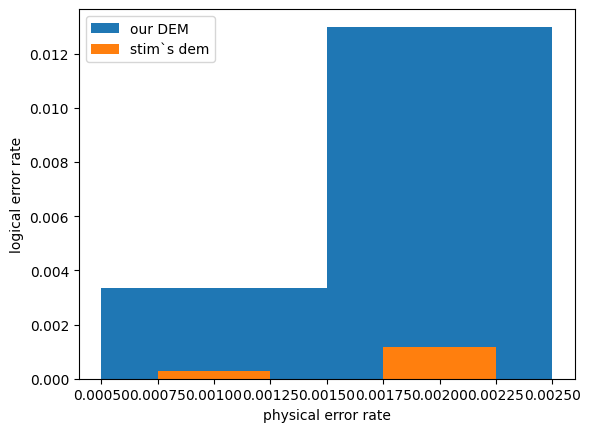

In [ ]:
from matplotlib import pyplot as plt

plt.bar(x=pvals,height=my_LE,width=0.001)
plt.bar(x=pvals,height=stims_LE,width=0.0005)
plt.xlabel('physical error rate')
plt.ylabel('logical error rate')
plt.legend(['our DEM','stim`s dem'])
plt.show()


In [ ]:
#Check 3-point probabilities (I think what we obtain is acceptable)
org_DEM      = {}
p_3cnts      = {}

triplets                  = [(0,0),(0,1),(0,2)] #D0-D1-D2
p_3cnts[("D0","D1","D2")] = get_3Point_prob(defects_matrix,num_shots,triplets)
triplets                  = [(1,0),(1,1),(1,2)] #D3-D4-D5
p_3cnts[("D3","D4","D5")] = get_3Point_prob(defects_matrix,num_shots,triplets)

#-------- Calculate by excluding other nodes that fire ------------------

include_pairs             = [(0,1),(0,2),(1,0)] #D1-D2-D3:
exclude_pairs             = [(1,1),(1,2),(0,0)] # seems to work better if i remove D0 or D6...
p_3cnts[("D1","D2","D3")] = get_3Point_prob_exclude(defects_matrix,num_shots,include_pairs,exclude_pairs)

include_pairs             = [(0,1),(1,0),(1,2)] #D1-D3-D5:
exclude_pairs             = [(0,0),(0,2),(1,1)] #
p_3cnts[("D1","D3","D5")] = get_3Point_prob_exclude(defects_matrix,num_shots,include_pairs,exclude_pairs)


#Add 3 pnt events to original DEM
for key in p_3cnts.keys():
    org_DEM[key] = p_3cnts[key]

org_DEM



Alt for D1 D2 D3: 0.00090625


{('D0', 'D1', 'D2'): 0.00194125,
 ('D3', 'D4', 'D5'): 0.00278,
 ('D1', 'D2', 'D3'): 0.00083125,
 ('D1', 'D3', 'D5'): 0.000795}

Let's try now to infer the errors of the original DEM

In [ ]:
#D0, D1, D2 are first rd.  D3, D4, D5, are 2nd rd.

#Find when the red nodes fire (exclude blue & green nodes) but allow the other red to fire

#D2 
target_node                 = (0,2) #(rd,anc)
exclude_nodes               = [(0,0),(0,1),(1,0),(1,1),(1,2)] #D0, D1, D3, D4
D2_cnts_wo_L0, D2_cnts_w_L0 = extract_single_counts_w_and_wo_L0_excluding_nodes(num_shots,obs_flips,defects_matrix,target_node,exclude_nodes)

#D5
target_node                 = (1,2) #(rd,anc)
exclude_nodes               = [(0,0),(0,1),(1,0),(1,1),(0,2)] #D0, D1, D3, D4
D5_cnts_wo_L0, D5_cnts_w_L0 = extract_single_counts_w_and_wo_L0_excluding_nodes(num_shots,obs_flips,defects_matrix,target_node,exclude_nodes)

print("D5 w/ L0:", D5_cnts_w_L0)
print("D5 wo/ L0:", D5_cnts_wo_L0)

print("D2 w/ L0:", D2_cnts_w_L0)
print("D2 wo/ L0:", D2_cnts_wo_L0)


#D0
target_node                 = (0,0) #(rd,anc)
exclude_nodes               = [(0,1),(0,2),(1,0),(1,1),(1,2)] #D1, D2, D4, D5
D0_cnts_wo_L0, D0_cnts_w_L0 = extract_single_counts_w_and_wo_L0_excluding_nodes(num_shots,obs_flips,defects_matrix,target_node,exclude_nodes)


#D1
target_node                 = (0,1) #(rd,anc)
exclude_nodes               = [(0,0),(0,2),(1,0),(1,1),(1,2)] #D1, D2, D4, D5
D1_cnts_wo_L0, D1_cnts_w_L0 = extract_single_counts_w_and_wo_L0_excluding_nodes(num_shots,obs_flips,defects_matrix,target_node,exclude_nodes)


#D3
target_node                 = (1,0) #(rd,anc)
exclude_nodes               = [(0,0),(0,1),(0,2),(1,1),(1,2)] #D1, D2, D4, D5
D3_cnts_wo_L0, D3_cnts_w_L0 = extract_single_counts_w_and_wo_L0_excluding_nodes(num_shots,obs_flips,defects_matrix,target_node,exclude_nodes)

#D4
target_node                 = (1,1) #(rd,anc)
exclude_nodes               = [(0,0),(0,1),(0,2),(1,0),(1,2)] #D1, D2, D4, D5
D4_cnts_wo_L0, D4_cnts_w_L0 = extract_single_counts_w_and_wo_L0_excluding_nodes(num_shots,obs_flips,defects_matrix,target_node,exclude_nodes)


print("D0 w/ L0:", D0_cnts_w_L0)
print("D0 wo/ L0:", D0_cnts_wo_L0)

print("D1 w/ L0:", D1_cnts_w_L0)
print("D1 wo/ L0:", D1_cnts_wo_L0)

print("D3 w/ L0:", D3_cnts_w_L0)
print("D3 wo/ L0:", D3_cnts_wo_L0)

print("D4 w/ L0:", D4_cnts_w_L0)
print("D4 wo/ L0:", D4_cnts_wo_L0)


#Pretty good, add this to original DEM

org_DEM[("D5","L0")]=D5_cnts_w_L0
org_DEM[("D2","L0")]=D2_cnts_w_L0


D5 w/ L0: 0.0005849999999999972
D5 wo/ L0: 0.0044300000000000225
D2 w/ L0: 0.000539999999999999
D2 wo/ L0: 0.001814999999999947
D0 w/ L0: 0.004490000000000041
D0 wo/ L0: 1.25e-05
D1 w/ L0: 0.0031074999999998946
D1 wo/ L0: 0.0012062499999999719
D3 w/ L0: 0.0037787499999998673
D3 wo/ L0: 6.0000000000000076e-05
D4 w/ L0: 0.00322124999999989
D4 wo/ L0: 3.875000000000002e-05


In [ ]:
#Add other bulk edges to org_DEM:

org_DEM[("D2","D5")]=pij_bulk[("D2","D5")]
org_DEM[("D1","D4")]=pij_bulk[("D1","D4")]
org_DEM[("D0","D3")]=pij_bulk[("D0","D3")]

Use 3-point events to find 2-point events

In [ ]:
#Estimate other events by subtracting the 3 point events

org_DEM[("D0","D1","L0")] = (pij_bulk[("D0","D1")]-p_3cnts[("D0","D1","D2")])/(1-2*p_3cnts[("D0","D1","D2")])
org_DEM[("D0","D2")]      = (pij_bulk[("D0","D2")]-p_3cnts[("D0","D1","D2")])/(1-2*p_3cnts[("D0","D1","D2")])
org_DEM[("D4","D5")]      = (pij_bulk[("D4","D5")]-p_3cnts[("D3","D4","D5")])/(1-2*p_3cnts[("D3","D4","D5")])
org_DEM[("D1","D5")]      = (pij_bulk[("D1","D5")]-p_3cnts[("D1","D3","D5")])/((1-2*p_3cnts[("D1","D3","D5")]))
org_DEM[("D2","D3")]      = (pij_bulk[("D2","D3")]-p_3cnts[("D1","D2","D3")])/(1-2*p_3cnts[("D1","D2","D3")])
org_DEM[("D3","D4","L0")] = (pij_bulk[("D3","D4")]-p_3cnts[("D3","D4","D5")])/(1-2*p_3cnts[("D3","D4","D5")])




org_DEM[("D1","D2")]      = (pij_bulk[("D1","D2")]-p_3cnts[("D0","D1","D2")]-p_3cnts[("D1","D2","D3")])/((1-2*p_3cnts[("D0","D1","D2")])*(1-2*p_3cnts[("D1","D2","D3")]))
org_DEM[("D1","D3","L0")] = (pij_bulk[("D1","D3")]-p_3cnts[("D1","D3","D5")]-p_3cnts[("D1","D2","D3")])/((1-2*p_3cnts[("D1","D3","D5")])*(1-2*p_3cnts[("D1","D2","D3")]))
org_DEM[("D3","D5")]      = (pij_bulk[("D3","D5")]-p_3cnts[("D3","D4","D5")]-p_3cnts[("D1","D3","D5")])/((1-2*p_3cnts[("D3","D4","D5")])*(1-2*p_3cnts[("D1","D3","D5")]))

# org_DEM[("D3","D5")]      = (pij_bulk[("D3","D5")]-p_3cnts[("D3","D4","D5")]-p_3cnts[("D1","D2","D3")])/((1-2*p_3cnts[("D3","D4","D5")])*(1-2*p_3cnts[("D1","D2","D3")]))





org_DEM[("D4","L0")] = (DEM1[("D4","L8")]-org_DEM[("D4","D5")])/(1-2*org_DEM[("D4","D5")])
org_DEM[("D0","L0")] = (DEM1[("D0","L1")]-org_DEM[("D0","D2")])/(1-2*org_DEM[("D0","D2")])
org_DEM[("D3","L0")] = (DEM1[("D3","L6")]-org_DEM[("D3","D5")]-org_DEM[("D2","D3")])/((1-2*org_DEM[("D3","D5")])*(1-2*org_DEM[("D2","D3")]))
org_DEM[("D3","D4","L0")] = (pij_bulk[("D3","D4")]-p_3cnts[("D3","D4","D5")])/(1-2*p_3cnts[("D3","D4","D5")])




# These 2 methods are pretty close.
# p_tempD1D3L0 = (pij_bulk[("D1","D3")]-p_3cnts[("D1","D3","D5")])/(1-2*p_3cnts[("D1","D3","D5")])
# p_tempD1D3L0 = (p_tempD1D3L0-p_3cnts[("D1","D2","D3")])/(1-2*p_3cnts[("D1","D2","D3")])
# p_Other_D1D3_L0 = (pij_bulk[("D1","D3")]-p_3cnts[("D1","D3","D5")]-p_3cnts[("D1","D2","D3")])/((1-2*p_3cnts[("D1","D3","D5")])*(1-2*p_3cnts[("D1","D2","D3")]))
# print("Method 1 for D1-D3 L0:",p_tempD1D3L0)
# print("Method 2 for D1-D3 L0:",p_Other_D1D3_L0)


org_DEM

{('D5', 'L0'): 0.0005666666666666668,
 ('D2', 'L0'): 0.0005266666666666663,
 ('D2', 'D5'): 0.005224605344912314,
 ('D1', 'D4'): 0.004946275099007524,
 ('D0', 'D3'): 0.005218004841540447,
 ('D0', 'D1', 'D2'): 0.0019533333333333334,
 ('D3', 'D4', 'D5'): 0.00285,
 ('D1', 'D2', 'D3'): 0.0008333333333333334,
 ('D1', 'D3', 'D5'): 0.00079,
 ('D0', 'D1', 'L0'): 0.0011491160873009988,
 ('D0', 'D2'): 0.0026608091696335165,
 ('D4', 'D5'): 0.004605189455622341,
 ('D1', 'D5'): 0.001341364937918964,
 ('D2', 'D3'): 0.0007455931865941428,
 ('D3', 'D4', 'L0'): 0.002753805037931625,
 ('D1', 'D2'): 0.0013227128075973466,
 ('D1', 'D3', 'L0'): 0.002641515195146791,
 ('D3', 'D5'): 0.003543353634664246,
 ('D4', 'L0'): 0.003665430891833692,
 ('D0', 'L0'): 0.0047260020622971214,
 ('D3', 'L0'): 0.004009290159801043}

In [ ]:
#Add 3 point events in org_DEM
p_org_DEM              = {}
p_org_DEM[("D1","D2","D3")] = p_3cnts[("D1","D2","D3")]
p_org_DEM[("D0","D1","D2")] = p_3cnts[("D0","D1","D2")]
p_org_DEM[("D3","D4","D5")] = p_3cnts[("D3","D4","D5")]
p_org_DEM[("D1","D3","D5")] = p_3cnts[("D1","D3","D5")]

In [ ]:
#Add the D2 L0, D2 , D5 L0, D5

p_org_DEM[("D2","L0")]=v_D2_w_L0
p_org_DEM[("D2","")]=v_D2_wo_L0
p_org_DEM[("D5","")]=v_D5_wo_L0
p_org_DEM[("D5","L0")]=v_D5_w_L0
p_org_DEM[("D1","L0")]=v_D1_w_L0
p_org_DEM[("D1","")]=v_D1_wo_L0



In [ ]:
#Use the 3-point events to find probs in original DEM


p_org_DEM[("D2","D5")] = pij_bulk[("D2","D5")]
p_org_DEM[("D1","D4")] = pij_bulk[("D1","D4")]
p_org_DEM[("D0","D3")] = pij_bulk[("D0","D3")]

p_org_DEM[("D2","D3")] = (pij_bulk[("D2","D3")]-p_3cnts[("D1","D2","D3")])/(1-2*p_3cnts[("D1","D2","D3")])
p_org_DEM[("D0","D1","L0")] = (pij_bulk[("D0","D1")]-p_3cnts[("D0","D1","D2")])/(1-2*p_3cnts[("D0","D1","D2")])
p_org_DEM[("D3","D4","L0")] = (pij_bulk[("D3","D4")]-p_3cnts[("D3","D4","D5")])/(1-2*p_3cnts[("D3","D4","D5")])
p_org_DEM[("D4","D5")] = (pij_bulk[("D4","D5")]-p_3cnts[("D3","D4","D5")])/(1-2*p_3cnts[("D3","D4","D5")])
p_org_DEM[("D0","D2")] = (pij_bulk[("D0","D2")]-p_3cnts[("D0","D1","D2")])/(1-2*p_3cnts[("D0","D1","D2")])

p_org_DEM[("D3","D5")] = (pij_bulk[("D3","D5")]-p_3cnts[("D3","D4","D5")]-p_3cnts[("D1","D2","D3")])/((1-2*p_3cnts[("D3","D4","D5")])*(1-2*p_3cnts[("D1","D2","D3")]))


# p_org_DEM[("D1","D3")] = (pij_bulk[("D1","D3")]-p_3cnts[("D1","D3","D5")])/(1-2*p_3cnts[("D1","D3","D5")])
p_org_DEM[("D1","D2")] = (pij_bulk[("D1","D2")]-p_3cnts[("D0","D1","D2")]-p_3cnts[("D1","D2","D3")])/((1-2*p_3cnts[("D0","D1","D2")])*(1-2*p_3cnts[("D1","D2","D3")]))

#Maybe this is a bit off?
p_org_DEM[("D1","D5")] = (pij_bulk[("D1","D5")]-p_3cnts[("D1","D3","D5")])/((1-2*p_3cnts[("D1","D3","D5")]))


#Use D0 L1 in new dem to estimate D0 L0 in original dem: looks good
p_org_DEM[("D0","L0")] = (pij_bd[("D0","L1")]-p_org_DEM[("D0","D2")])/(1-2*p_org_DEM[("D0","D2")])

#Use D4 L8 in new dem to estimate D4 L0 in original dem: looks good
p_org_DEM[("D4","L0")] = (pij_bd[("D4","L8")]-p_org_DEM[("D4","D5")])/(1-2*p_org_DEM[("D4","D5")])

#Use D3 D4 L7 to construct D3 D4 L0 via D3 D4 D5
p_org_DEM[("D3","D4","D5")] = p_3cnts[("D3","D4","D5")]

#Use D3 D5, D2 D3 from org dem and D3 L6 from DEM 1 to get D3 L0 in org DEM: close enough
p_org_DEM[("D3","L0")] = (pij_bd[("D3","L6")]-p_org_DEM[("D3","D5")]-p_org_DEM[("D2","D3")])/((1-2*p_org_DEM[("D3","D5")])*(1-2*p_org_DEM[("D2","D3")]))


#Get D1 D3 L0 of org_DEM from D1 D3 of DEM1 and from D1D3D5 and D1D2D3: close enough
p_org_DEM[("D1","D3","L0")] = (pij_bulk[("D1","D3")]-p_3cnts[("D1","D3","D5")]-p_3cnts[("D1","D2","D3")])/((1-2*p_3cnts[("D1","D3","D5")])*(1-2*p_3cnts[("D1","D2","D3")]))
p_org_DEM[("D1","D3","D5")] = p_3cnts[("D1","D3","D5")]
p_org_DEM[("D1","D2","D3")] = p_3cnts[("D1","D2","D3")]

#use D0 D2 in org_dem and D0 L1 in DEM1 to construct D0 L0 in org_dem
p_org_DEM[("D0","L0")] = (pij_bd[("D0","L1")]-p_org_DEM[("D0","D2")])/(1-2*p_org_DEM[("D0","D2")])


p_org_DEM


{('D1', 'D2', 'D3'): 9.2e-05,
 ('D0', 'D1', 'D2'): 0.009684,
 ('D3', 'D4', 'D5'): 0.009687,
 ('D1', 'D3', 'D5'): 0.0001135,
 ('D2', 'L0'): 0.0002695000000000033,
 ('D2', ''): 0.008791999999998466,
 ('D5', ''): 0.008783499999998457,
 ('D5', 'L0'): 0.00025900000000000304,
 ('D1', 'L0'): 0.009041999999998716,
 ('D1', ''): 0.0002490000000000028,
 ('D2', 'D5'): 3.90680368087537e-05,
 ('D1', 'D4'): 0,
 ('D0', 'D3'): 3.0684276601300464e-05,
 ('D2', 'D3'): -7.401373840190307e-05,
 ('D0', 'D1', 'L0'): 0.01029991348786124,
 ('D3', 'D4', 'L0'): 0.010182750195801959,
 ('D4', 'D5'): 0.01031549825247557,
 ('D0', 'D2'): 0.010271769192823849,
 ('D3', 'D5'): 0.010228872578725637,
 ('D1', 'D2'): 0.010164960141099112,
 ('D1', 'D5'): -0.0001135257703498694,
 ('D0', 'L0'): 0.00973743611323074,
 ('D4', 'L0'): 0.009774244876919726,
 ('D3', 'L0'): 0.009845764042186182,
 ('D1', 'D3', 'L0'): -0.00019891887482728727}

In [ ]:
#I think dem2 (M_red only) has red detectors, virtual detectors and logical observables
#Then, dem1 (M_restricted) has no red detectors. It has blue, green detectors, and virtual observables?

#So the question is: to what actual detector each virtual observable relates to? What probabilities does it combine?
#Then, if we know this, we can just use our estimates instead of relying on Stim's DEM.

#So dem2 for each error instruction in the M_{ZX}, it adds the target if it is a red detector
#then it adds another virtual detector with id = num_detectors + virtual_obs_id (latter is of dem1)
#and it adds an observable L0 under some condition.
#The probability is already the probability found in the decomposition + compression above


In [ ]:
det, obs = obj.sample(10000)

np.shape(det)

(10000, 6)

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       ...,
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [ ]:
circuit.dee

In [ ]:
dets = np.reshape(defects_matrix.data,(num_shots,num_ancilla*(num_rounds+1)))

preds_obs, best_color = obj.decode(dets, dems, verbose=True, get_color=True)

color r, step-1 decoding..


ValueError: `shots` array should have at least 5 columns (the number of detectors), and no more than 5 columns (the number of nodes), but instead has 6 columns

In [ ]:
preds_obs  # Predictions of logical observables

array([False, False, False, ..., False, False, False])

In [ ]:
best_color  # Selected best colors

array(['r', 'r', 'r', ..., 'r', 'r', 'r'], dtype='<U1')

In [ ]:
fails = np.logical_xor(obs, preds_obs)
fails

array([False, False, False, ..., False, False, False])

In [ ]:
print("Number of failures:", np.sum(fails))

Number of failures: 43
